# MFCC / speaker prediction / LSTM

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()
print(obj)

[(103, 1), (1034, 0), (1040, 0), (1069, 1), (1081, 0), (1088, 1), (1098, 1), (1116, 1), (118, 0), (1183, 1), (1235, 0), (1246, 1), (125, 1), (1263, 1), (1334, 0), (1355, 0), (1363, 1), (1447, 1), (1455, 0), (150, 1), (1502, 1), (1553, 1), (1578, 1), (1594, 0), (1624, 0), (163, 0), (1723, 0), (1737, 1), (1743, 0), (1841, 1), (1867, 0), (1898, 1), (19, 1), (1926, 1), (196, 0), (1963, 1), (1970, 1), (198, 1), (1992, 1), (200, 1), (2002, 0), (2007, 1), (201, 0), (2092, 1), (211, 1), (2136, 0), (2159, 0), (2182, 1), (2196, 1), (226, 1), (2289, 0), (229, 0), (233, 0), (2384, 0), (2391, 1), (2416, 1), (2436, 0), (248, 1), (250, 1), (2514, 0), (2518, 0), (254, 0), (26, 0), (2691, 1), (27, 0), (2764, 1), (2817, 1), (2836, 1), (2843, 0), (289, 1), (2893, 0), (2910, 1), (2911, 0), (2952, 0), (298, 1), (2989, 1), (302, 1), (307, 0), (311, 0), (3112, 1), (3168, 0), (32, 1), (3214, 0), (322, 1), (3235, 1), (3240, 0), (3242, 0), (3259, 1), (328, 1), (332, 0), (3374, 0), (3436, 0), (3440, 1), (3486, 0

In [3]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [4]:
gender_dict = {k:v for k,v in obj}

In [5]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data


def write_wav(file_path, fs, data):
    from scipy.io.wavfile import write
    try:
        write(file_path,fs, data)
        return 1
    except:
        return 0


- sampling rate = 16000 Hz
- 200,000点で，200,000/16,000  = 12.5 sec
- 50 msec くらいで切りたいので，
- 50*10^-3 * 16,000 = 800 点ずつ切ればいい？
- 2の累乗にすると1024くらい？(0.064 sec)

In [32]:
import pickle
with open("mfcc_lstm_data_4096.dump","rb") as f:
    (all_data, all_labels, all_speakers) = pickle.load(f,encoding="bytes")

In [33]:
all_data.shape

(15237, 4096)

In [ ]:
frame_length = 10000
stride = 2500

all_data = np.empty((0,frame_length), int)
all_labels = []
all_speakers = []

cnt = 0
for path in glob.glob("wav_samples/*"):
    fs,data = load_wav(path)
    print(cnt,path)
    
    frame_num = int((data.shape[0]-frame_length)/stride) 
    for i in range(frame_num):
        all_data = np.append(all_data, np.array([data[i*stride:i*stride+frame_length]]), axis=0)

    label = gender_dict[int(path.split("/")[1].split("-")[0])]
    all_labels.extend([label]*frame_num)
    all_speakers.extend([cnt]*frame_num)
    
    cnt += 1
#     if cnt > 80:
#         break
    
print(all_data.shape)
all_labels = np.array(all_labels)

0 wav_samples/103-1240-0000.flac.wav
1 wav_samples/1034-121119-0000.flac.wav
2 wav_samples/1040-133433-0000.flac.wav
3 wav_samples/1069-133699-0000.flac.wav
4 wav_samples/1081-125237-0000.flac.wav
5 wav_samples/1088-129236-0000.flac.wav
6 wav_samples/1098-133695-0000.flac.wav
7 wav_samples/1116-132847-0000.flac.wav
8 wav_samples/118-121721-0000.flac.wav
9 wav_samples/1183-124566-0000.flac.wav
10 wav_samples/1235-135883-0000.flac.wav
11 wav_samples/1246-124548-0000.flac.wav
12 wav_samples/125-121124-0000.flac.wav
13 wav_samples/1263-138246-0000.flac.wav
14 wav_samples/1334-135589-0000.flac.wav
15 wav_samples/1355-39947-0000.flac.wav
16 wav_samples/1363-135842-0000.flac.wav
17 wav_samples/1447-130550-0000.flac.wav
18 wav_samples/1455-134435-0000.flac.wav
19 wav_samples/150-126107-0000.flac.wav
20 wav_samples/1502-122615-0000.flac.wav
21 wav_samples/1553-140047-0000.flac.wav
22 wav_samples/1578-140045-0000.flac.wav
23 wav_samples/1594-135914-0000.flac.wav
24 wav_samples/1624-142933-0000.f

In [208]:
# import pickle
# with open("mfcc_lstm_data_10000.dump","wb") as f:
#     pickle.dump((all_data, all_labels, all_speakers),f)

In [34]:
print(all_data.shape)
print(all_labels.shape)
# print(all_speakers.shape)

(15237, 4096)
(15237,)


In [35]:
def dens_threshold(data, th, win=100):
    # 閾値
    L = len(data)
    abs_sum = []
    for i in range(int(L/100)):
        d = data[i*100:(i+1)*100]
        abs_sum.append(np.sum(np.array([np.abs(x) for x in d]))//100.)

    pos = 0; neg = 0
    for i in abs_sum:
        if i >= 800.:
            pos += 1
        else:
            neg += 1
#     print("pos:",pos,"neg:",neg,"/",int(L/100))
    if pos/int(L/100) > 0.5:
        return 1
    else:
        return 0

In [36]:
all_data_label_speaker = np.array([(x,y,z) for x,y,z in zip(all_data,all_labels,all_speakers) if dens_threshold(x, 800)])

all_data = np.array([x for x,y,z in all_data_label_speaker])
all_labels = np.array([y for x,y,z in all_data_label_speaker])
all_speakers = np.array([z for x,y,z in all_data_label_speaker])

In [37]:
all_data.shape

(5591, 4096)

In [39]:
x_train = all_data[:5000]
y_train = all_labels[:5000]
x_test = all_data[5000:]
y_test = all_labels[5000:]
s_train = all_speakers[:5000]
s_test = all_speakers[5000:]

In [205]:
path ="./wav_samples/103-1240-0000.flac.wav"
fs,data = load_wav(path)
write_wav("test.wav",fs,data[:20000])

1

[622.0, 306.0, 414.0, 245.0, 149.0, 169.0, 164.0, 118.0, 97.0, 190.0, 248.0, 304.0, 783.0, 1216.0, 1530.0, 1941.0, 1743.0, 1047.0, 737.0, 430.0, 440.0, 1181.0, 1348.0, 1477.0, 1652.0, 1513.0, 1427.0, 1295.0, 1316.0, 1084.0, 1031.0, 1017.0, 1077.0, 1034.0, 838.0, 1148.0, 959.0, 884.0, 1087.0, 839.0]
pos: 27 neg: 13 / 40
mean: 33736.8533414 std: 51396.4318059 mean/std: 0.656404582108
153535.495089 711251.974384 0.215866529189
max-val: 711251.974384 max-freq: 281.25 max/std: 13.8385477239
mfcc shape (20, 1)


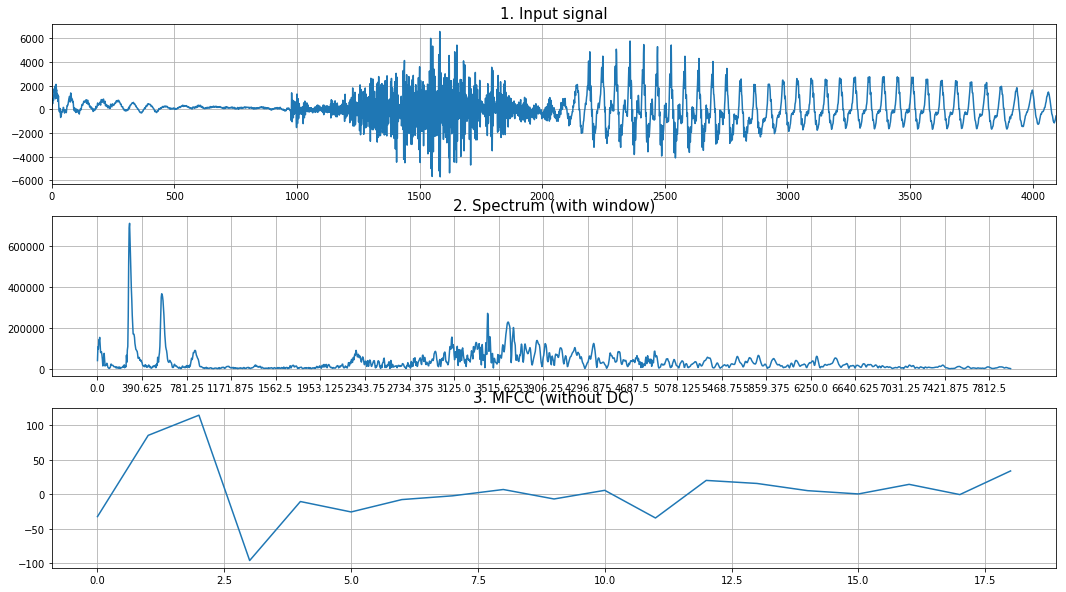

[201.0, 372.0, 925.0, 1258.0, 1592.0, 2079.0, 1554.0, 915.0, 672.0, 434.0, 483.0, 1354.0, 1523.0, 1409.0, 1466.0, 1552.0, 1524.0, 1196.0, 1247.0, 1111.0, 1082.0, 1048.0, 850.0, 1160.0, 966.0, 906.0, 1069.0, 956.0, 941.0, 885.0, 574.0, 630.0, 454.0, 443.0, 141.0, 252.0, 681.0, 708.0, 600.0, 765.0]
pos: 32 neg: 8 / 40
mean: 19836.0387676 std: 52991.7101547 mean/std: 0.374323431149
249972.342689 977288.667808 0.255781480869
max-val: 977288.667808 max-freq: 277.34375 max/std: 18.4422934258
mfcc shape (20, 1)


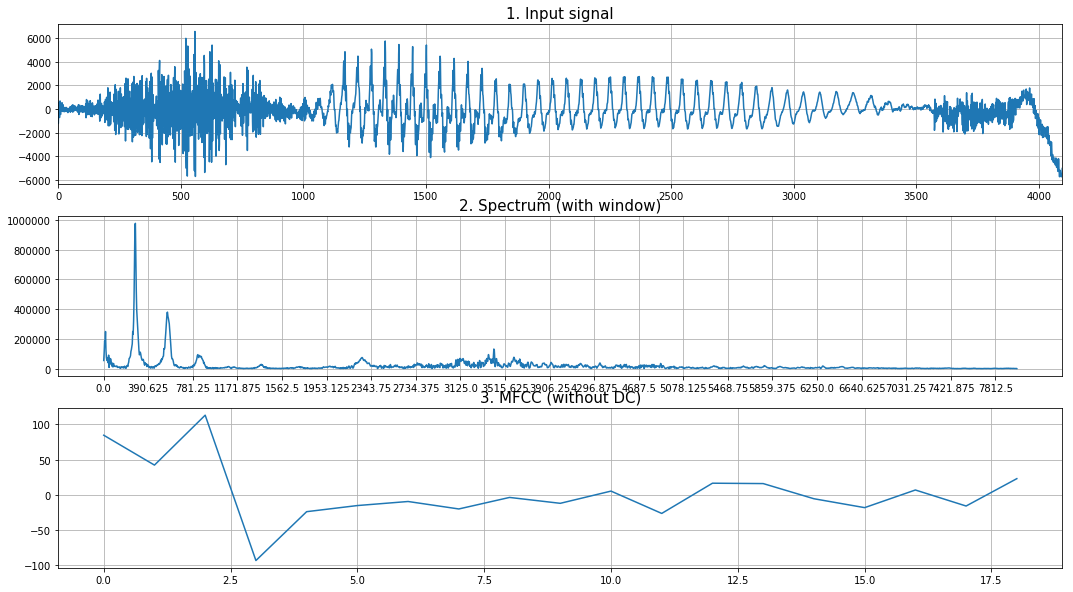

[675.0, 1416.0, 1329.0, 1617.0, 1623.0, 1411.0, 1305.0, 1426.0, 1163.0, 1108.0, 930.0, 1118.0, 987.0, 948.0, 1049.0, 989.0, 934.0, 1060.0, 904.0, 765.0, 654.0, 489.0, 603.0, 251.0, 143.0, 365.0, 717.0, 638.0, 601.0, 1082.0, 3787.0, 1723.0, 1027.0, 1076.0, 1659.0, 2394.0, 1316.0, 1515.0, 2202.0, 1516.0]
pos: 36 neg: 4 / 40
mean: 17819.9515074 std: 43331.1315311 mean/std: 0.411250546148
496715.838165 619658.303238 0.801596356523
max-val: 619658.303238 max-freq: 269.53125 max/std: 14.3005336197
mfcc shape (20, 1)


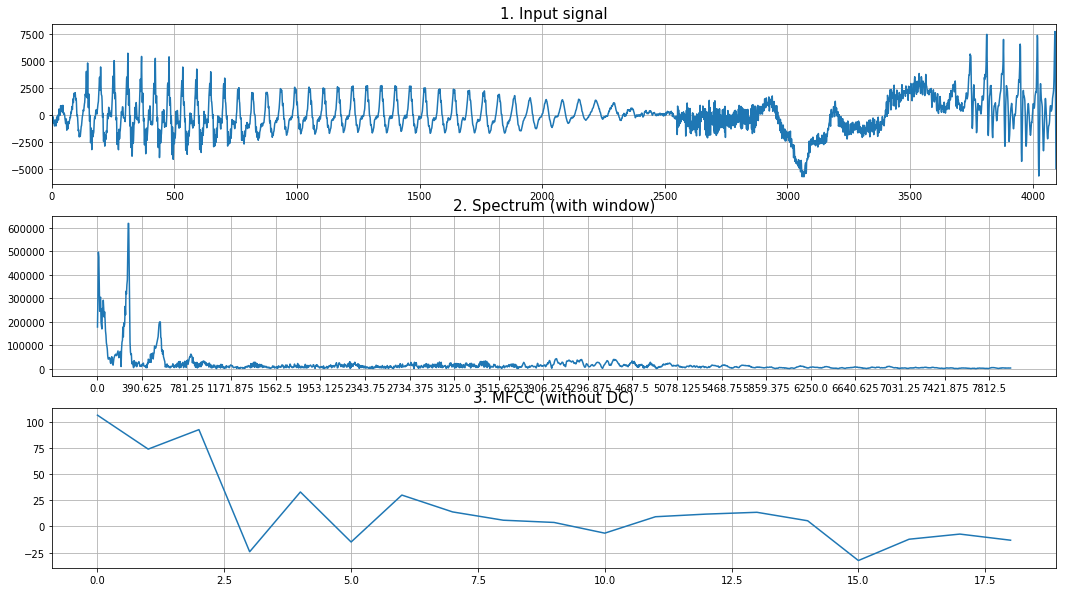

[1002.0, 949.0, 1055.0, 1046.0, 986.0, 944.0, 1011.0, 970.0, 973.0, 711.0, 561.0, 594.0, 454.0, 217.0, 148.0, 518.0, 763.0, 540.0, 697.0, 1385.0, 3830.0, 1255.0, 1249.0, 984.0, 1991.0, 2110.0, 1201.0, 2109.0, 1660.0, 1874.0, 2071.0, 1916.0, 3153.0, 2880.0, 2642.0, 2989.0, 2732.0, 2217.0, 2231.0, 2490.0]
pos: 37 neg: 3 / 40
mean: 32930.1628867 std: 67190.3980235 mean/std: 0.490102214831
1150699.74142 583721.006315 1.97131802517
max-val: 1150699.74142 max-freq: 11.71875 max/std: 17.1259551255
mfcc shape (20, 1)


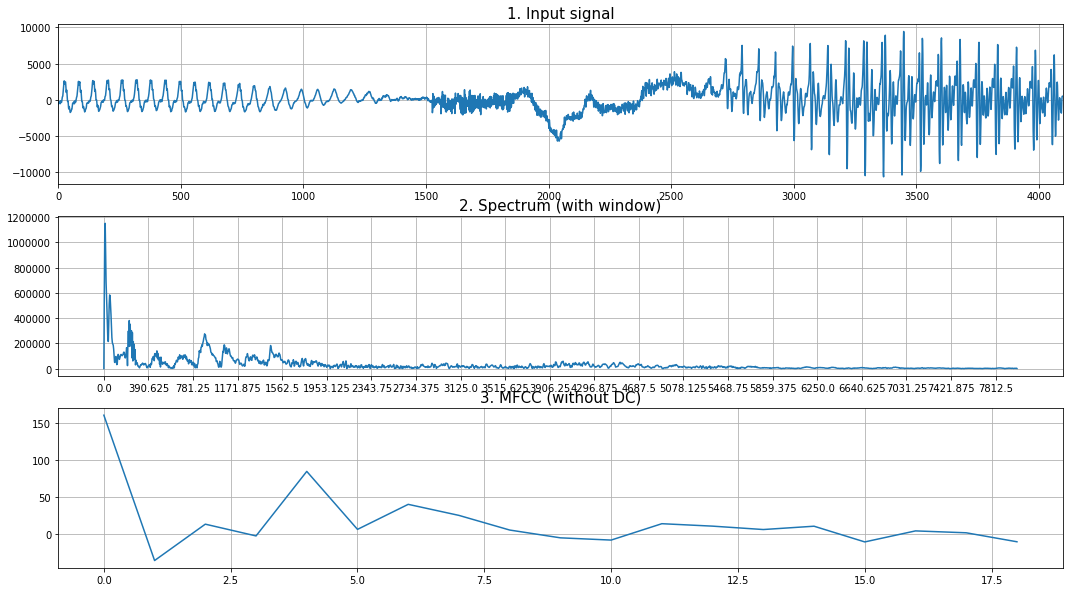

[509.0, 597.0, 363.0, 250.0, 132.0, 661.0, 726.0, 533.0, 807.0, 2122.0, 3408.0, 964.0, 1242.0, 1113.0, 2241.0, 1612.0, 1737.0, 1773.0, 1700.0, 2039.0, 1789.0, 2638.0, 2726.0, 2649.0, 3289.0, 2710.0, 2427.0, 2351.0, 2599.0, 1862.0, 1830.0, 2319.0, 1781.0, 1750.0, 2453.0, 2068.0, 1854.0, 1840.0, 1875.0, 1358.0]
pos: 37 neg: 3 / 40
mean: 45993.6606514 std: 103585.258115 mean/std: 0.444017435379
887949.709306 954757.970507 0.930025971748
max-val: 954757.970507 max-freq: 1460.9375 max/std: 9.21712208744
mfcc shape (20, 1)


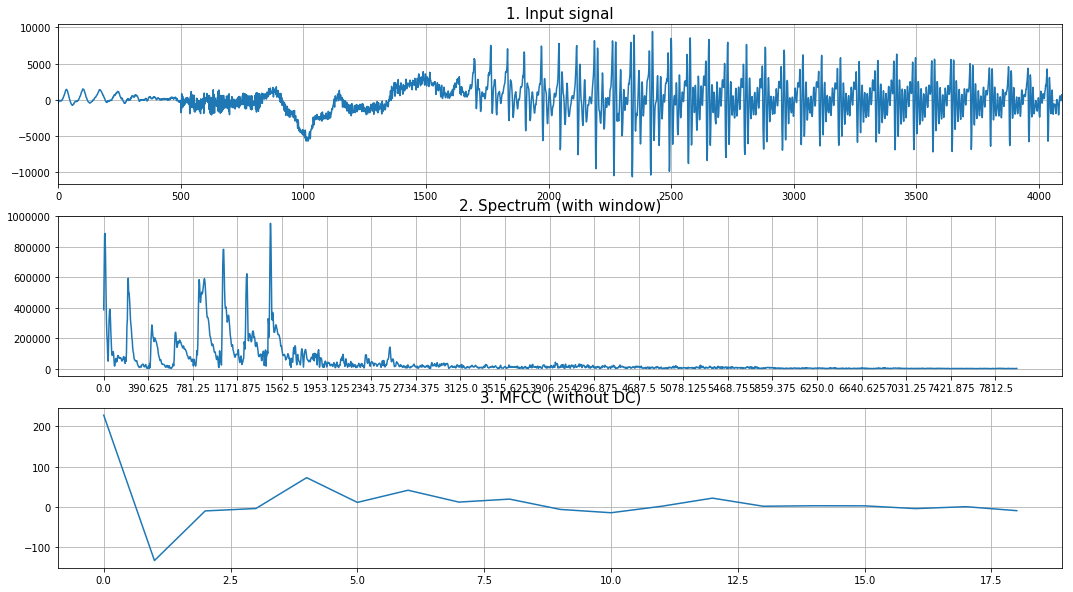

[2607.0, 845.0, 1165.0, 1266.0, 2485.0, 1304.0, 1803.0, 1628.0, 2035.0, 1702.0, 2351.0, 2446.0, 2414.0, 3433.0, 2824.0, 2564.0, 2546.0, 2653.0, 1969.0, 1897.0, 2345.0, 1829.0, 1733.0, 2252.0, 2134.0, 1903.0, 2004.0, 1984.0, 1505.0, 1318.0, 1618.0, 1209.0, 1090.0, 1199.0, 1259.0, 1073.0, 878.0, 1046.0, 919.0, 899.0]
pos: 40 neg: 0 / 40
mean: 38064.6400242 std: 106586.201428 mean/std: 0.357125401921
310867.169289 1393173.15906 0.22313605977
max-val: 1393173.15906 max-freq: 1460.9375 max/std: 13.0708585201
mfcc shape (20, 1)


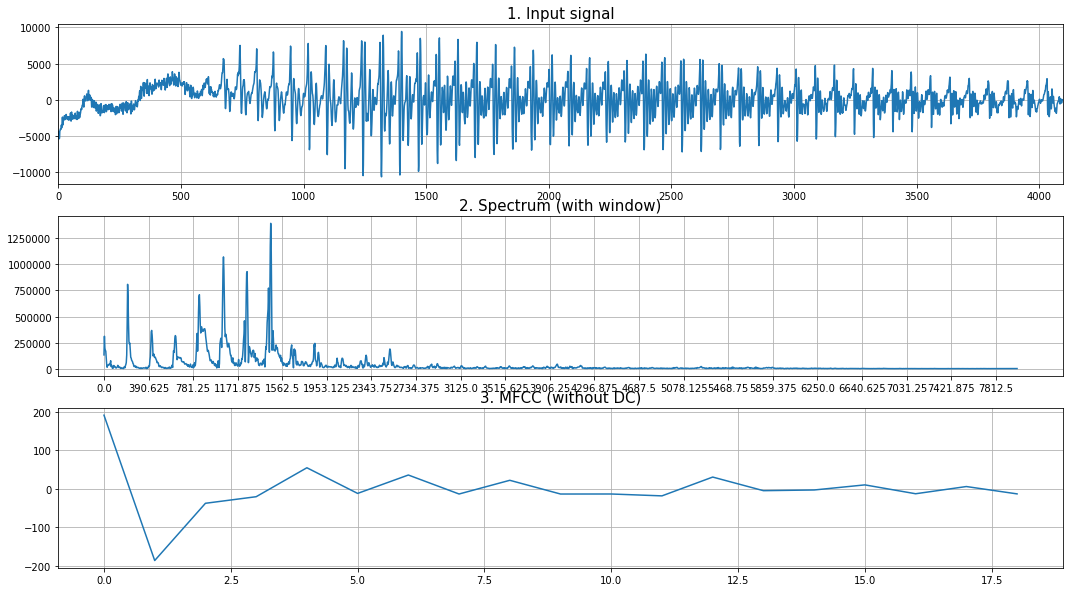

[2233.0, 2230.0, 3204.0, 3014.0, 2666.0, 2748.0, 2709.0, 2091.0, 1991.0, 2432.0, 1808.0, 1798.0, 2140.0, 2062.0, 1951.0, 2188.0, 2070.0, 1623.0, 1402.0, 1725.0, 1266.0, 1127.0, 1212.0, 1281.0, 1122.0, 959.0, 1093.0, 913.0, 913.0, 774.0, 1061.0, 855.0, 861.0, 776.0, 943.0, 737.0, 726.0, 472.0, 630.0, 604.0]
pos: 39 neg: 1 / 40
mean: 26073.7152665 std: 75477.6344061 mean/std: 0.345449555642
178658.272608 812731.733588 0.219824408504
max-val: 812731.733588 max-freq: 203.125 max/std: 10.7678485154
mfcc shape (20, 1)


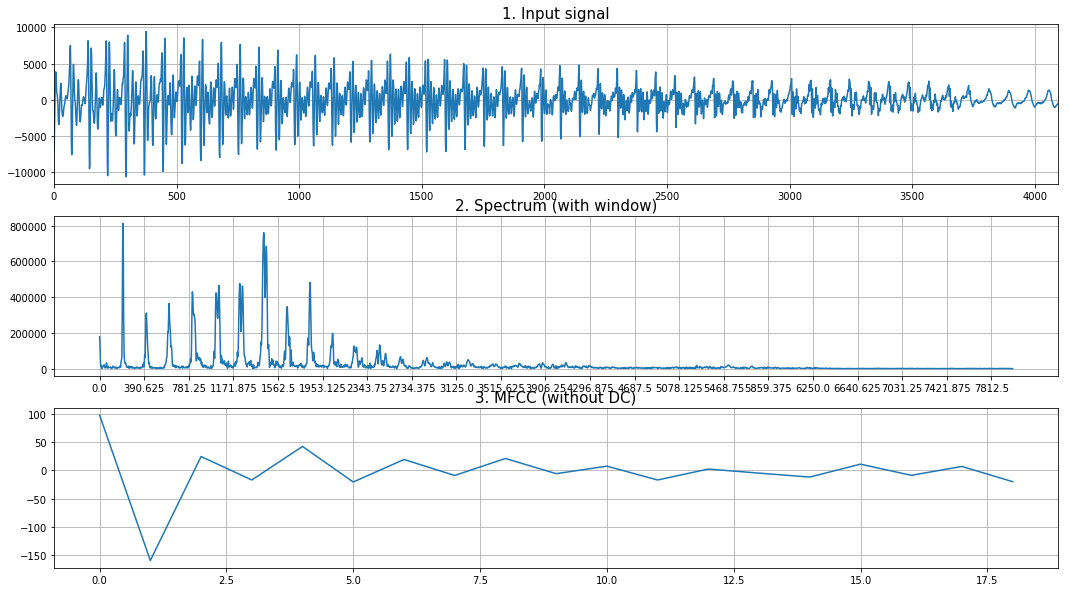

[1791.0, 2207.0, 1889.0, 1932.0, 2275.0, 2175.0, 1751.0, 1542.0, 1849.0, 1323.0, 1137.0, 1398.0, 1169.0, 1182.0, 1030.0, 1161.0, 937.0, 890.0, 856.0, 980.0, 909.0, 845.0, 844.0, 952.0, 750.0, 772.0, 622.0, 604.0, 592.0, 573.0, 551.0, 621.0, 546.0, 513.0, 410.0, 536.0, 465.0, 449.0, 373.0, 327.0]
pos: 35 neg: 5 / 40
mean: 18196.6648642 std: 45695.2464355 mean/std: 0.398217895376
145267.730561 742171.777833 0.195733299082
max-val: 742171.777833 max-freq: 199.21875 max/std: 16.2417720819
mfcc shape (20, 1)


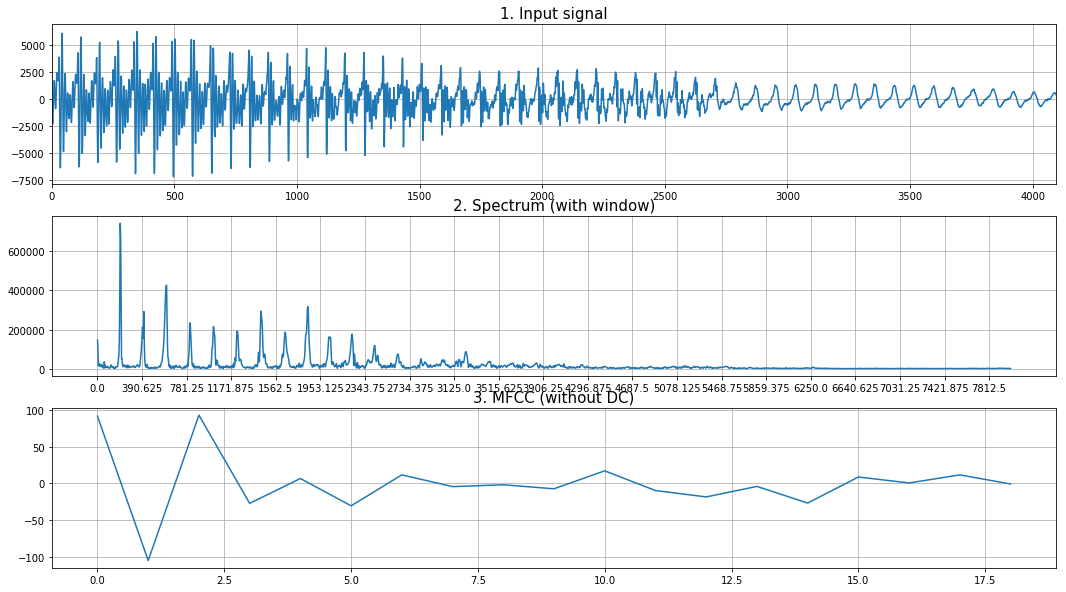

[709.0, 576.0, 635.0, 594.0, 544.0, 626.0, 555.0, 608.0, 573.0, 499.0, 513.0, 518.0, 482.0, 385.0, 391.0, 426.0, 400.0, 311.0, 654.0, 1209.0, 1406.0, 1424.0, 1365.0, 1629.0, 1577.0, 1561.0, 1477.0, 1750.0, 1942.0, 1784.0, 1774.0, 1720.0, 2050.0, 2038.0, 1842.0, 1669.0, 2002.0, 1985.0, 1802.0, 1626.0]
pos: 33 neg: 7 / 40
mean: 17459.5399732 std: 59557.2924321 mean/std: 0.293155367886
54857.1766224 1114166.16715 0.04923608187
max-val: 1114166.16715 max-freq: 585.9375 max/std: 18.7074684165
mfcc shape (20, 1)


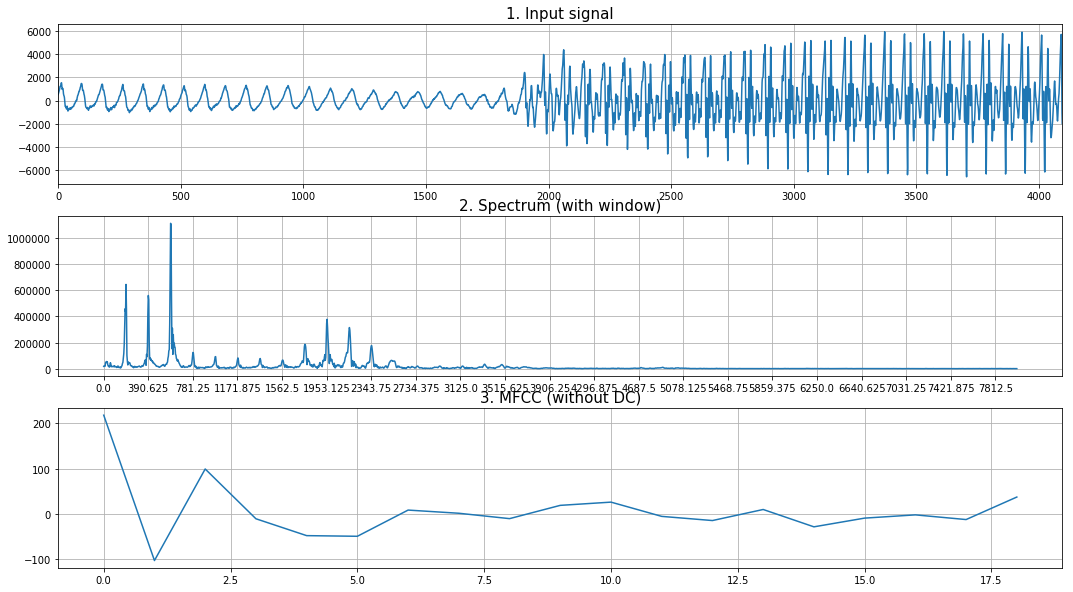

[557.0, 446.0, 473.0, 401.0, 387.0, 383.0, 373.0, 420.0, 814.0, 1223.0, 1339.0, 1493.0, 1594.0, 1415.0, 1506.0, 1480.0, 1805.0, 1766.0, 1827.0, 1647.0, 1834.0, 2108.0, 1853.0, 1858.0, 1679.0, 2038.0, 1965.0, 1826.0, 1624.0, 2012.0, 1819.0, 1717.0, 1453.0, 1720.0, 1420.0, 1330.0, 1314.0, 1176.0, 948.0, 713.0]
pos: 33 neg: 7 / 40
mean: 23042.6957746 std: 86289.3356753 mean/std: 0.267039902373
40494.6325557 1509027.16064 0.0268349262439
max-val: 1509027.16064 max-freq: 589.84375 max/std: 17.4879914051
mfcc shape (20, 1)


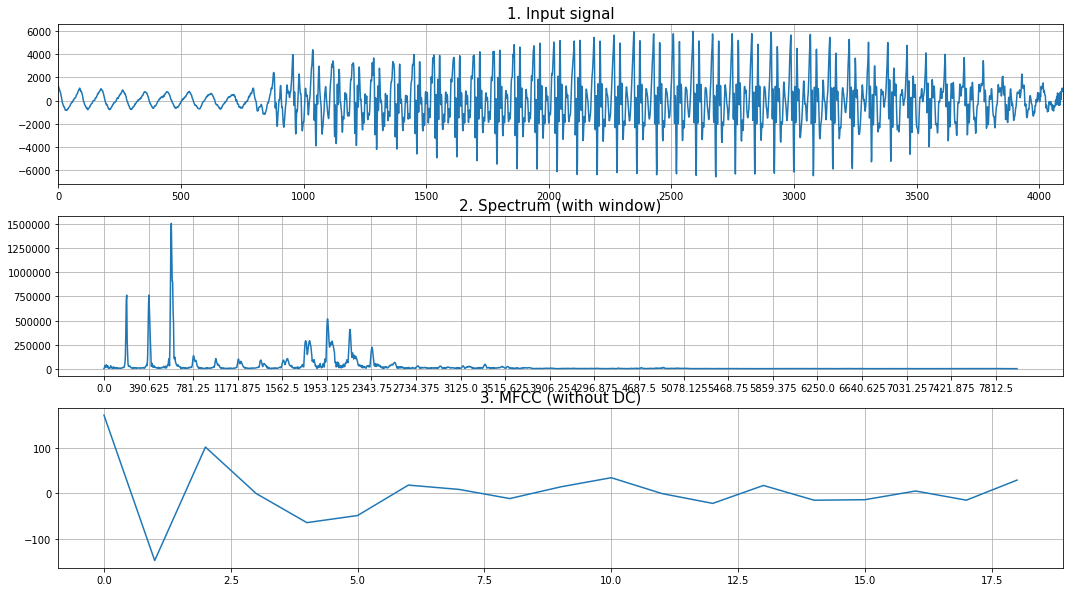

[1639.0, 1480.0, 1400.0, 1391.0, 1505.0, 1760.0, 1759.0, 1688.0, 1654.0, 1981.0, 1926.0, 1892.0, 1744.0, 1806.0, 2122.0, 1821.0, 1842.0, 1703.0, 2055.0, 1741.0, 1776.0, 1602.0, 1737.0, 1536.0, 1385.0, 1317.0, 1269.0, 1164.0, 851.0, 754.0, 506.0, 394.0, 618.0, 603.0, 469.0, 523.0, 710.0, 476.0, 585.0, 490.0]
pos: 36 neg: 4 / 40
mean: 25005.5084051 std: 81010.3648388 mean/std: 0.308670482535
38077.0042105 1329810.5176 0.0286334058172
max-val: 1329810.5176 max-freq: 601.5625 max/std: 16.4153132781
mfcc shape (20, 1)


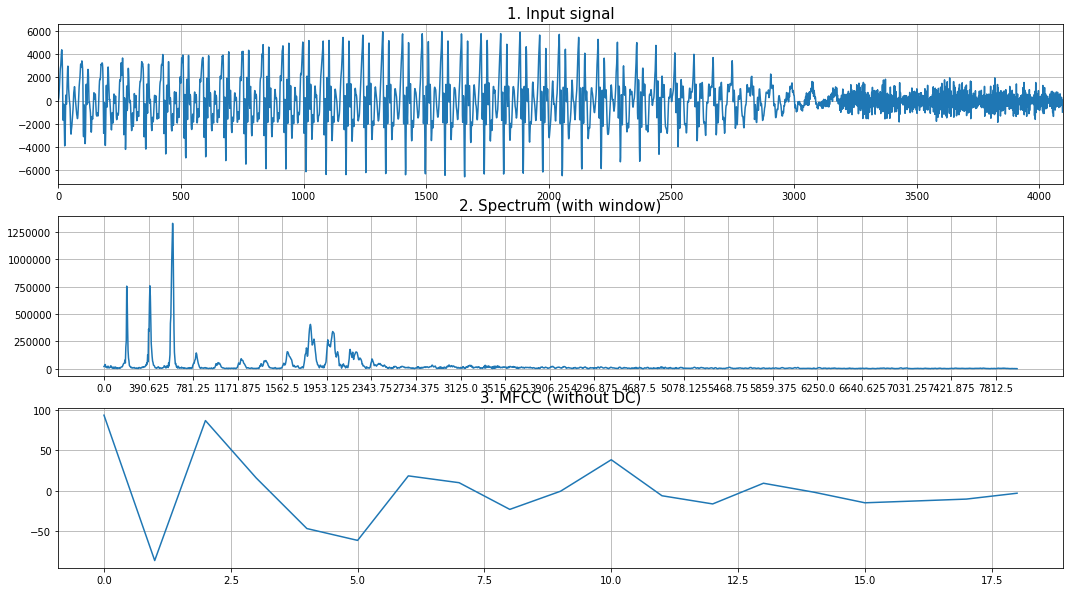

[80.0, 105.0, 80.0, 104.0, 90.0, 102.0, 87.0, 96.0, 91.0, 179.0, 425.0, 668.0, 819.0, 904.0, 907.0, 969.0, 1054.0, 1051.0, 1005.0, 1124.0, 1206.0, 1218.0, 1218.0, 1244.0, 1273.0, 1239.0, 1196.0, 1224.0, 1273.0, 1259.0, 1289.0, 1302.0, 1232.0, 1080.0, 779.0, 601.0, 410.0, 376.0, 349.0, 311.0]
pos: 25 neg: 15 / 40
mean: 11826.7581271 std: 48245.0799384 mean/std: 0.245139154961
43430.4209455 892339.188641 0.0486703055278
max-val: 892339.188641 max-freq: 332.03125 max/std: 18.4959624853
mfcc shape (20, 1)


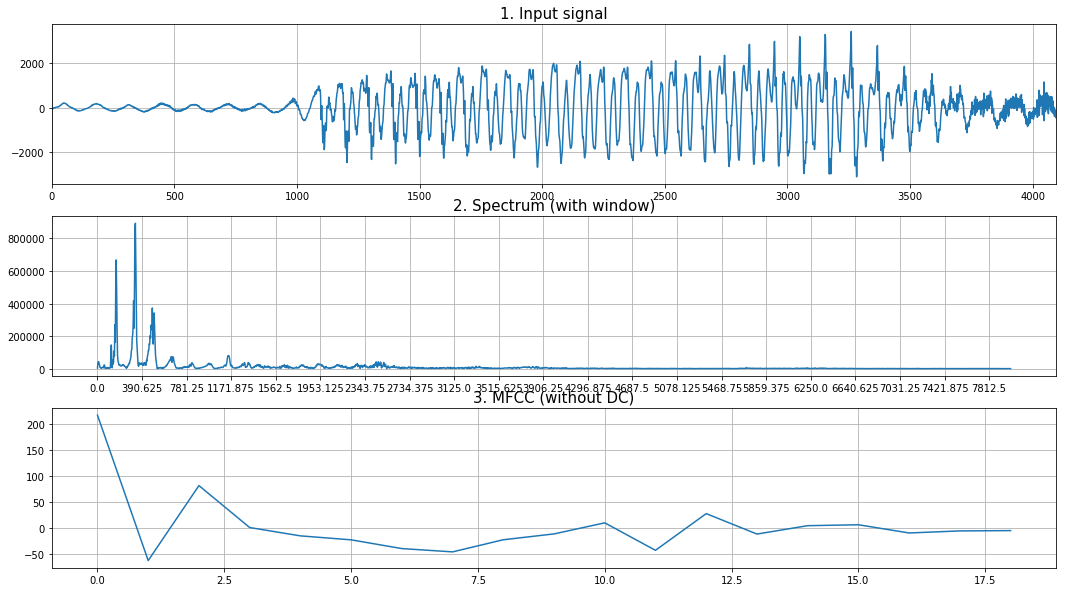

[588.0, 686.0, 821.0, 900.0, 908.0, 951.0, 990.0, 1030.0, 1076.0, 1163.0, 1250.0, 1230.0, 1190.0, 1289.0, 1283.0, 1236.0, 1213.0, 1239.0, 1274.0, 1254.0, 1229.0, 1245.0, 1235.0, 961.0, 862.0, 638.0, 291.0, 318.0, 348.0, 306.0, 378.0, 346.0, 449.0, 441.0, 577.0, 803.0, 1083.0, 1156.0, 1259.0, 1327.0]
pos: 32 neg: 8 / 40
mean: 14883.9015202 std: 46884.1155709 mean/std: 0.317461497118
67486.0249849 520197.846082 0.129731457931
max-val: 520197.846082 max-freq: 328.125 max/std: 11.0953963778
mfcc shape (20, 1)


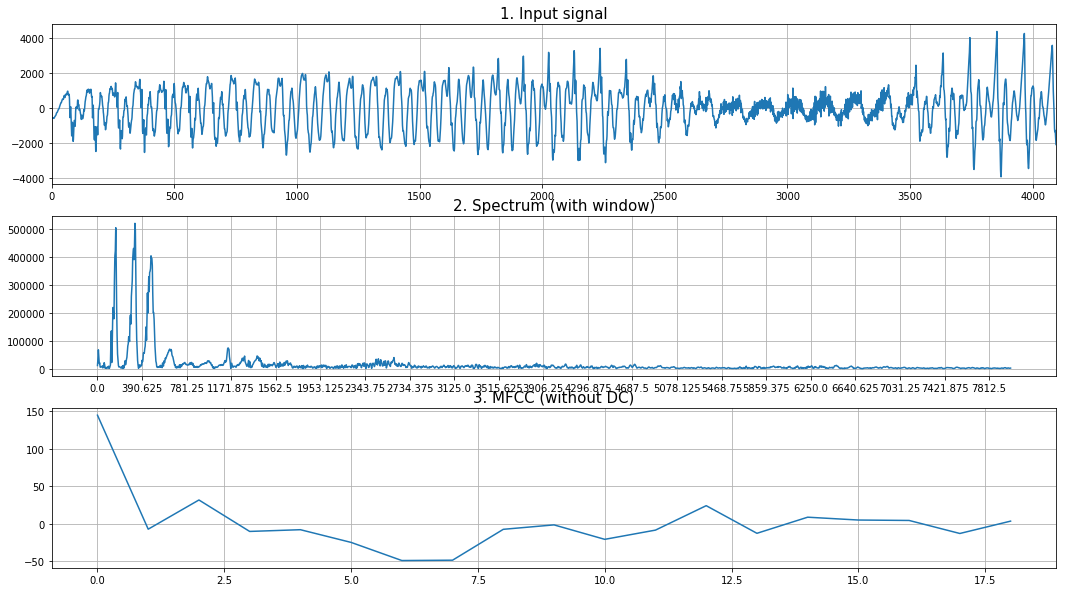

-------------------
-------------------
-------------------
[163.0, 107.0, 454.0, 852.0, 403.0, 966.0, 1490.0, 1519.0, 1401.0, 1465.0, 1332.0, 1285.0, 1036.0, 1042.0, 843.0, 738.0, 556.0, 402.0, 436.0, 441.0, 330.0, 298.0, 518.0, 570.0, 612.0, 794.0, 960.0, 1056.0, 848.0, 939.0, 1349.0, 1316.0, 1080.0, 1038.0, 1090.0, 855.0, 909.0, 1062.0, 786.0, 644.0]
pos: 31 neg: 9 / 40
mean: 15123.2562652 std: 35621.4493966 mean/std: 0.424554770268
34159.8601258 300537.377966 0.113662601161
max-val: 300537.377966 max-freq: 203.125 max/std: 8.43697780571
mfcc shape (20, 1)


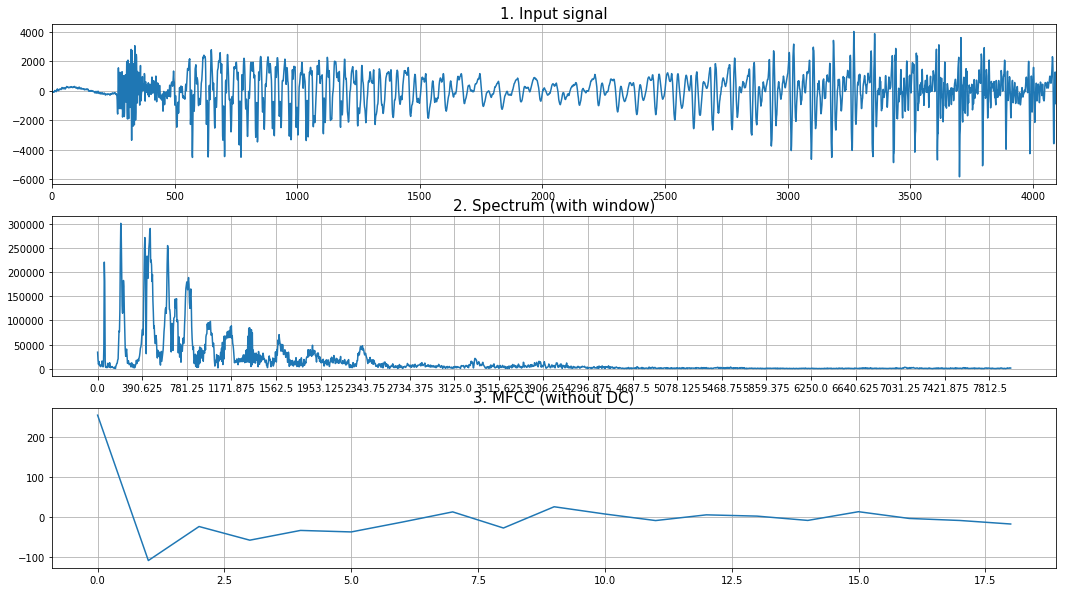

[678.0, 855.0, 1429.0, 1851.0, 1894.0, 1885.0, 1904.0, 1884.0, 2007.0, 2211.0, 2520.0, 2604.0, 2503.0, 2142.0, 1207.0, 1009.0, 863.0, 486.0, 266.0, 176.0, 190.0, 178.0, 147.0, 141.0, 304.0, 877.0, 980.0, 1005.0, 965.0, 829.0, 482.0, 478.0, 291.0, 244.0, 169.0, 423.0, 562.0, 790.0, 1044.0, 1092.0]
pos: 26 neg: 14 / 40
mean: 29730.3316518 std: 43866.6380838 mean/std: 0.677743564369
33368.1619966 635298.722968 0.0525235779488
max-val: 635298.722968 max-freq: 472.65625 max/std: 14.4825031213
mfcc shape (20, 1)


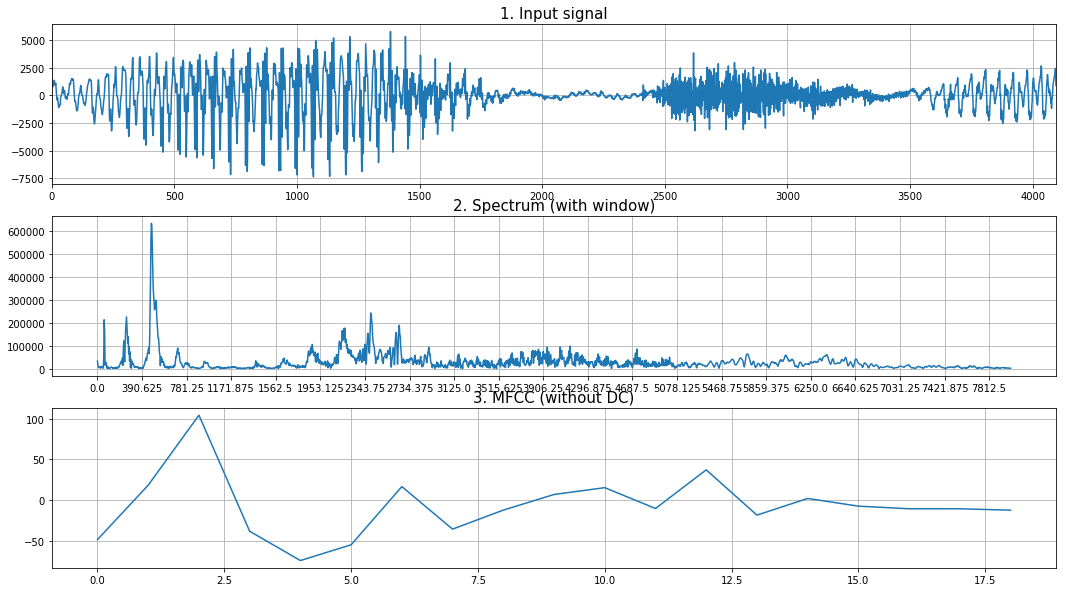

[2475.0, 2626.0, 2467.0, 1868.0, 1325.0, 815.0, 820.0, 405.0, 255.0, 165.0, 183.0, 180.0, 146.0, 164.0, 364.0, 1019.0, 964.0, 956.0, 1033.0, 690.0, 525.0, 375.0, 279.0, 237.0, 227.0, 358.0, 754.0, 925.0, 905.0, 1026.0, 1237.0, 1154.0, 1060.0, 1013.0, 1059.0, 938.0, 855.0, 841.0, 667.0, 689.0]
pos: 27 neg: 13 / 40
mean: 23583.7303855 std: 25639.3978757 mean/std: 0.919823878075
31550.6581398 325165.845044 0.0970294347354
max-val: 325165.845044 max-freq: 554.6875 max/std: 12.6822730635
mfcc shape (20, 1)


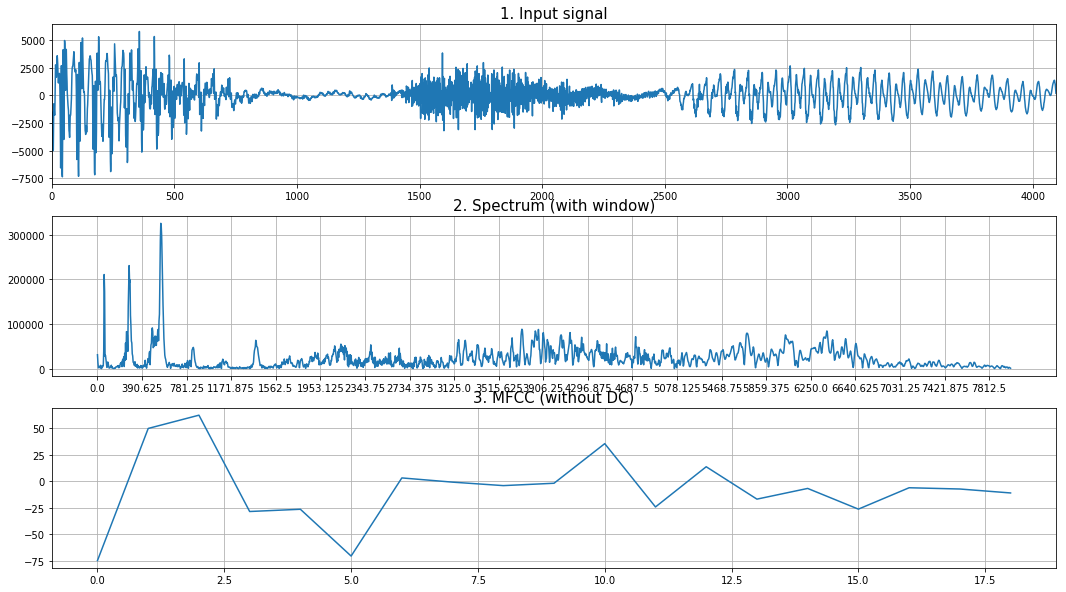

[1396.0, 1305.0, 1168.0, 1051.0, 872.0, 655.0, 571.0, 574.0, 610.0, 850.0, 1013.0, 1868.0, 1786.0, 997.0, 402.0, 583.0, 434.0, 383.0, 230.0, 164.0, 131.0, 273.0, 304.0, 303.0, 417.0, 415.0, 526.0, 696.0, 1015.0, 1708.0, 2296.0, 2437.0, 2696.0, 2542.0, 2388.0, 2682.0, 2275.0, 1916.0, 1334.0, 966.0]
pos: 29 neg: 11 / 40
mean: 24407.433677 std: 38225.181064 mean/std: 0.638517150151
26226.1885335 496353.133143 0.0528377616304
max-val: 496353.133143 max-freq: 527.34375 max/std: 12.9849779472
mfcc shape (20, 1)


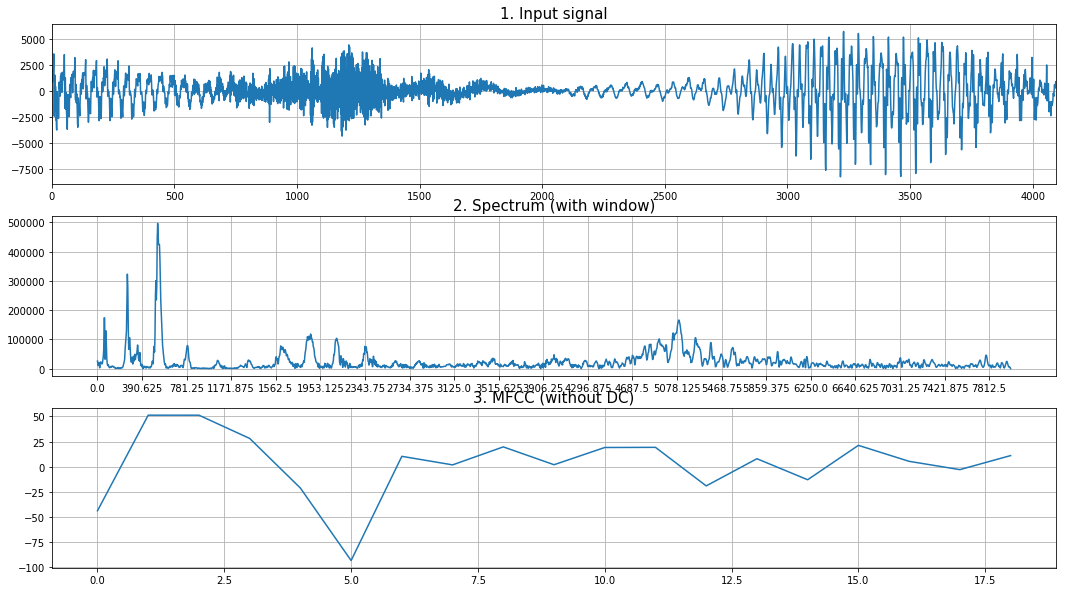

[2771.0, 2586.0, 2485.0, 2553.0, 2483.0, 2471.0, 2113.0, 1296.0, 1184.0, 816.0, 697.0, 413.0, 409.0, 329.0, 199.0, 186.0, 185.0, 142.0, 115.0, 391.0, 697.0, 1048.0, 1461.0, 1011.0, 745.0, 564.0, 329.0, 230.0, 287.0, 645.0, 848.0, 1252.0, 1576.0, 1524.0, 1719.0, 1537.0, 1539.0, 1371.0, 1521.0, 1056.0]
pos: 28 neg: 12 / 40
mean: 26709.0423329 std: 27969.2171529 mean/std: 0.954944222674
34756.3648884 390078.523964 0.0891009444333
max-val: 390078.523964 max-freq: 511.71875 max/std: 13.9467086916
mfcc shape (20, 1)


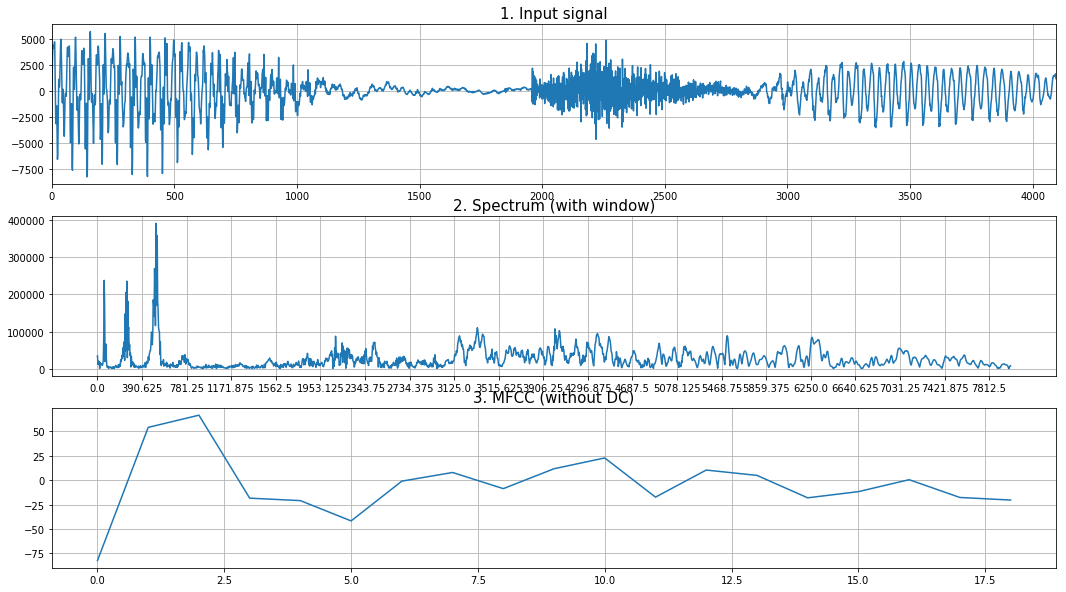

[1189.0, 1360.0, 1733.0, 1557.0, 1715.0, 1461.0, 1447.0, 1394.0, 1308.0, 818.0, 809.0, 742.0, 600.0, 599.0, 419.0, 442.0, 453.0, 414.0, 382.0, 445.0, 491.0, 494.0, 351.0, 431.0, 393.0, 441.0, 351.0, 586.0, 905.0, 908.0, 979.0, 1041.0, 915.0, 918.0, 951.0, 1038.0, 1051.0, 1113.0, 1125.0, 1102.0]
pos: 27 neg: 13 / 40
mean: 9535.07566036 std: 27452.1624792 mean/std: 0.347334227953
31137.1135944 337562.04266 0.0922411576524
max-val: 337562.04266 max-freq: 199.21875 max/std: 12.2963734793
mfcc shape (20, 1)


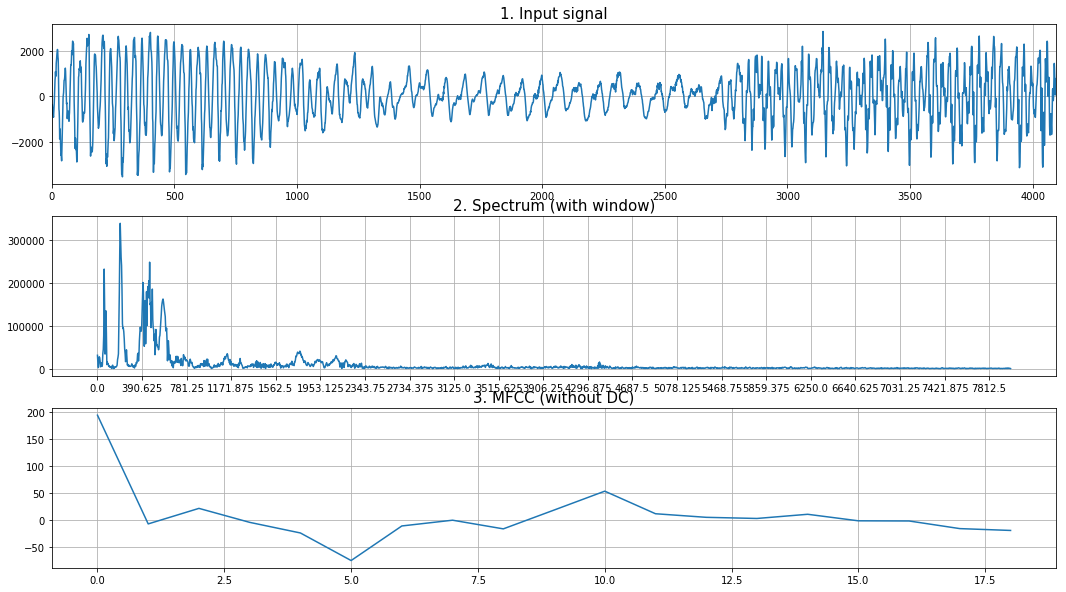

[548.0, 770.0, 898.0, 1205.0, 1445.0, 1645.0, 1802.0, 1746.0, 1551.0, 1578.0, 1359.0, 1048.0, 1026.0, 1096.0, 1157.0, 1095.0, 1193.0, 1058.0, 1059.0, 996.0, 770.0, 375.0, 214.0, 241.0, 226.0, 154.0, 201.0, 188.0, 355.0, 599.0, 761.0, 709.0, 582.0, 654.0, 670.0, 647.0, 817.0, 867.0, 914.0, 1095.0]
pos: 32 neg: 8 / 40
mean: 15232.3949596 std: 37865.7272508 mean/std: 0.402273931219
32625.734628 441142.901469 0.0739572925674
max-val: 441142.901469 max-freq: 441.40625 max/std: 11.6501895909
mfcc shape (20, 1)


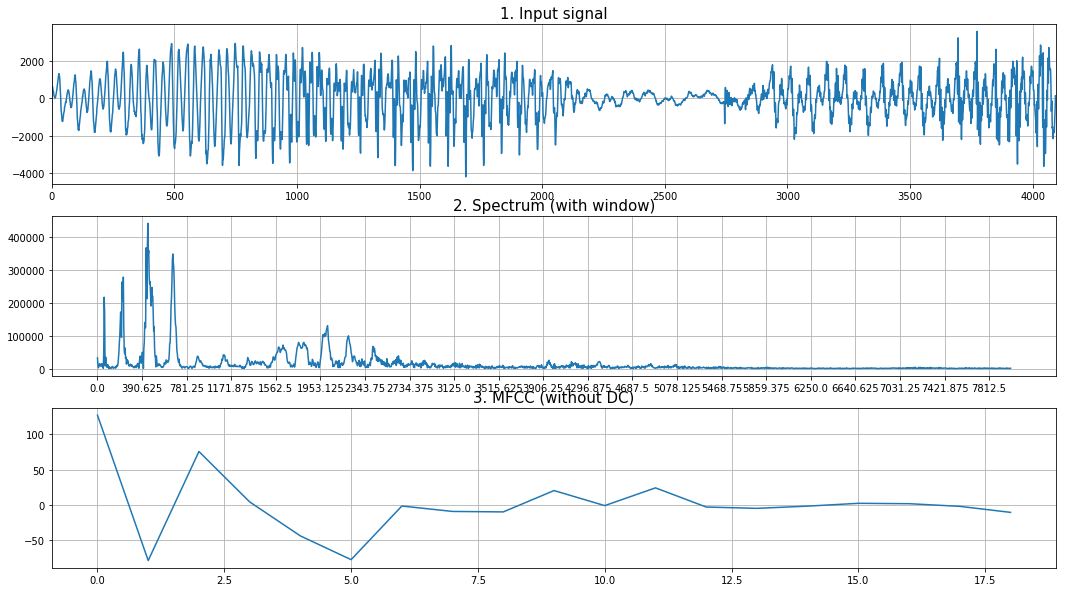

[887.0, 903.0, 970.0, 684.0, 249.0, 287.0, 261.0, 182.0, 92.0, 157.0, 189.0, 139.0, 95.0, 241.0, 466.0, 847.0, 1068.0, 1195.0, 1212.0, 1205.0, 1181.0, 1205.0, 1230.0, 1273.0, 1275.0, 1154.0, 1256.0, 1230.0, 1187.0, 1178.0, 962.0, 704.0, 607.0, 343.0, 287.0, 502.0, 639.0, 891.0, 1732.0, 1204.0]
pos: 27 neg: 13 / 40
mean: 18204.2965146 std: 45463.8216704 mean/std: 0.400412808377
29051.9517642 657252.666558 0.0442021055865
max-val: 657252.666558 max-freq: 453.125 max/std: 14.4566084066
mfcc shape (20, 1)


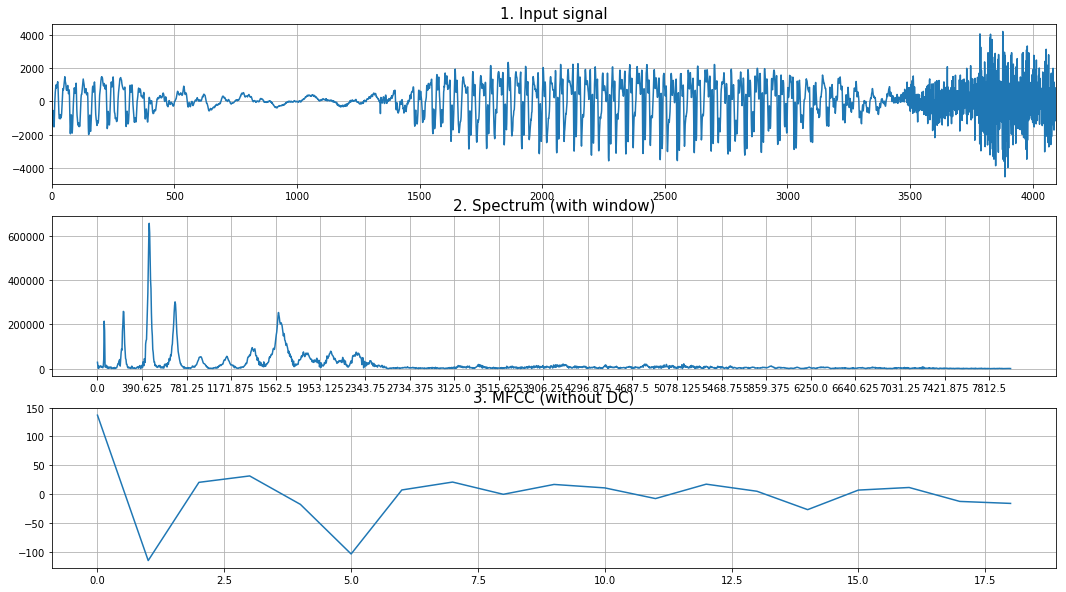

[205.0, 143.0, 159.0, 237.0, 521.0, 980.0, 1112.0, 1166.0, 1208.0, 1223.0, 1131.0, 1285.0, 1209.0, 1282.0, 1228.0, 1167.0, 1288.0, 1125.0, 1282.0, 1080.0, 937.0, 731.0, 488.0, 353.0, 316.0, 551.0, 667.0, 1027.0, 1710.0, 1139.0, 1176.0, 1138.0, 882.0, 739.0, 468.0, 226.0, 171.0, 213.0, 140.0, 109.0]
pos: 27 neg: 13 / 40
mean: 28260.5837713 std: 39616.9210989 mean/std: 0.713346292124
31400.2068393 510878.461423 0.061463164354
max-val: 510878.461423 max-freq: 460.9375 max/std: 12.8954610114
mfcc shape (20, 1)


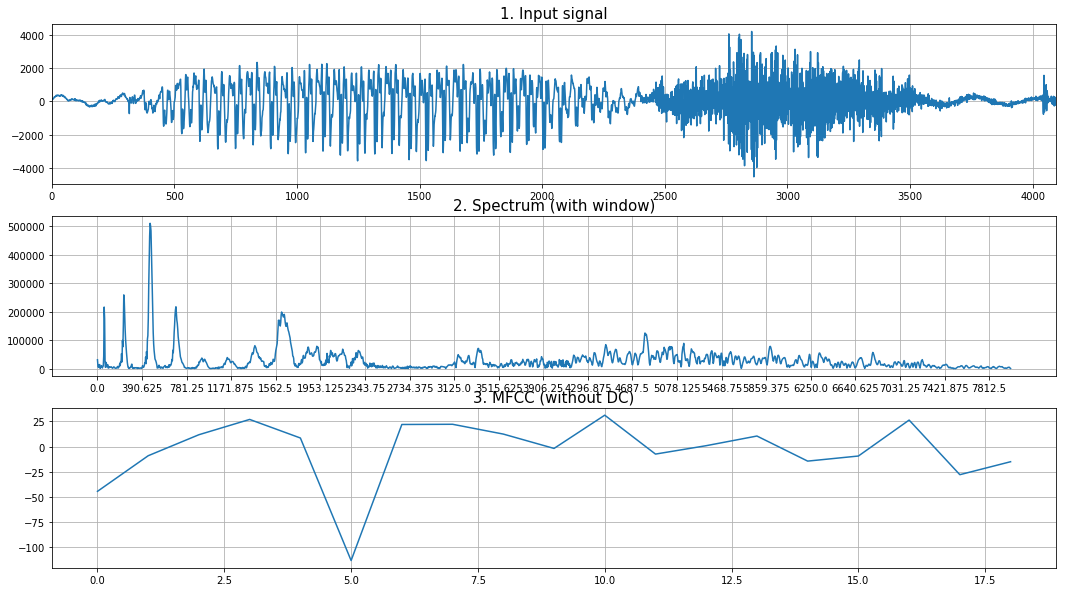

[624.0, 585.0, 193.0, 158.0, 151.0, 113.0, 123.0, 164.0, 132.0, 96.0, 116.0, 127.0, 224.0, 317.0, 1137.0, 1050.0, 1154.0, 985.0, 974.0, 1209.0, 1088.0, 977.0, 1186.0, 1096.0, 830.0, 817.0, 990.0, 943.0, 852.0, 959.0, 957.0, 927.0, 854.0, 1042.0, 1007.0, 1050.0, 980.0, 1152.0, 1223.0, 773.0]
pos: 28 neg: 12 / 40
mean: 24943.295754 std: 45962.9998763 mean/std: 0.54268206647
28838.8094517 383478.857514 0.0752031275952
max-val: 383478.857514 max-freq: 820.3125 max/std: 8.34320776595
mfcc shape (20, 1)


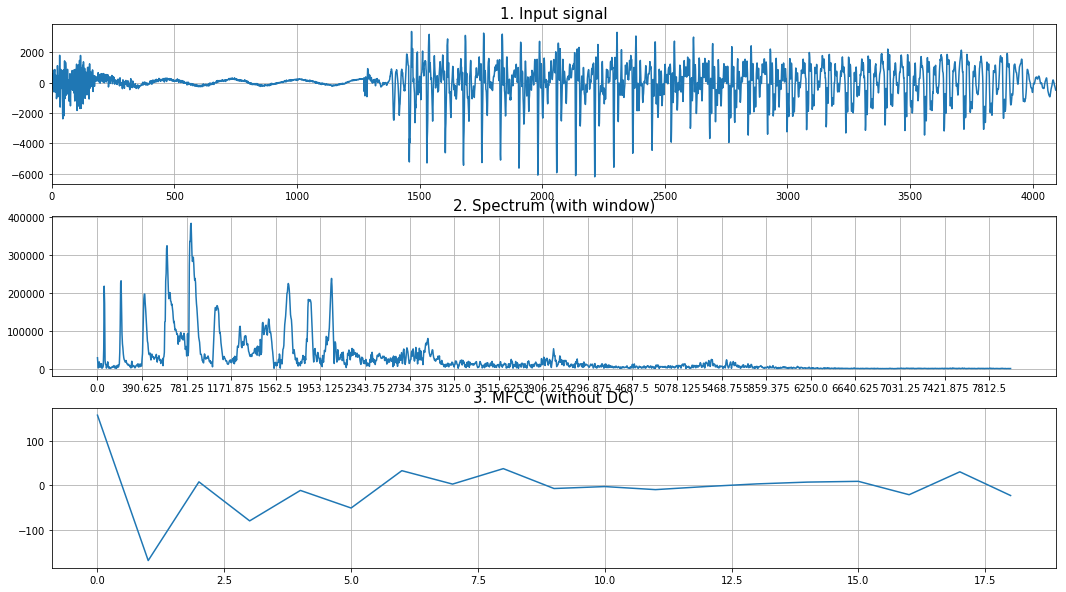

[89.0, 119.0, 237.0, 479.0, 1167.0, 1206.0, 1000.0, 960.0, 1173.0, 1026.0, 1001.0, 1232.0, 1099.0, 926.0, 854.0, 961.0, 930.0, 850.0, 970.0, 994.0, 884.0, 834.0, 1004.0, 1057.0, 949.0, 964.0, 1201.0, 1135.0, 1087.0, 619.0, 303.0, 307.0, 177.0, 187.0, 205.0, 150.0, 78.0, 152.0, 166.0, 150.0]
pos: 26 neg: 14 / 40
mean: 18992.8637698 std: 44080.4965872 mean/std: 0.430867736081
33716.9586328 636837.990222 0.0529443267369
max-val: 636837.990222 max-freq: 597.65625 max/std: 14.4471600714
mfcc shape (20, 1)


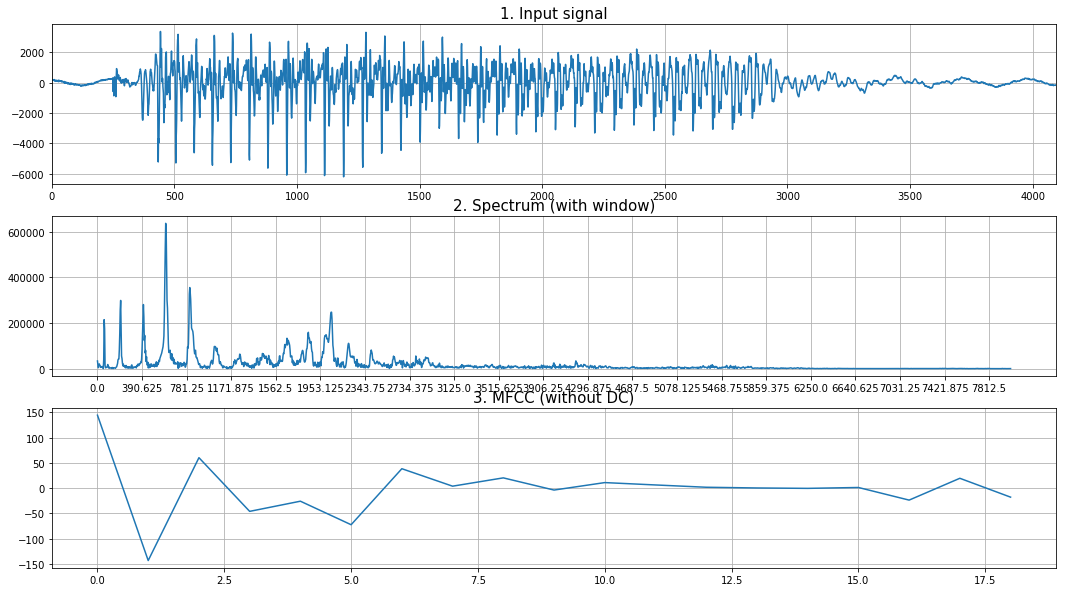

In [40]:
e = 0
for x,y in zip(x_train[500:700],y_train[500:700]):
    if y == 0:
        fft_plot(x,16000)
        e +=1
        write_wav("./{}_man.wav".format(e),16000,x)
    if e>12:
        break
    
print("-------------------")
print("-------------------")
print("-------------------")
        
e = 0
for x,y in zip(x_train[:100],y_train[:100]):
    if y == 1:
        fft_plot(x,16000)
        e +=1
        write_wav("./{}_woman.wav".format(e),16000,x)
    if e>12:
        break
        

In [41]:
print(x_train.shape)
print(x_test.shape)

(5000, 4096)
(591, 4096)


In [42]:
#     mfccs = mfcc(data, sr=fs, n_mfcc=30, n_fft=1024)
X_train = np.array([mfcc(x, sr=16000, n_mfcc=20, n_fft=4096) for x in x_train])
X_test = np.array([mfcc(x, sr=16000, n_mfcc=20, n_fft=4096) for x in x_test])

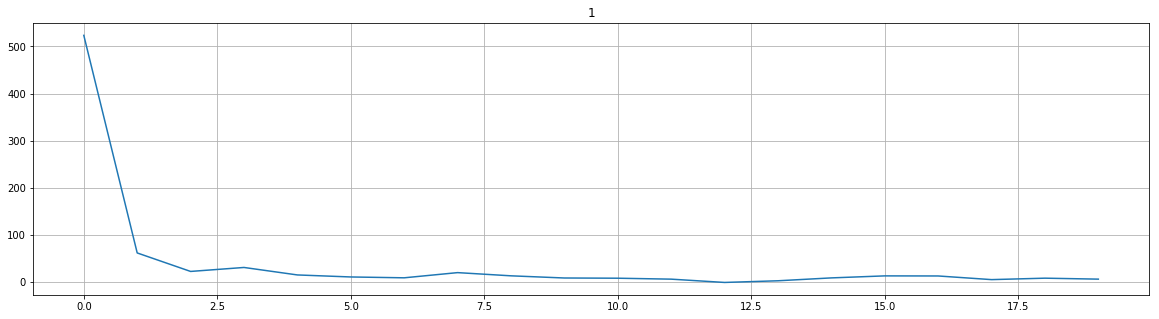

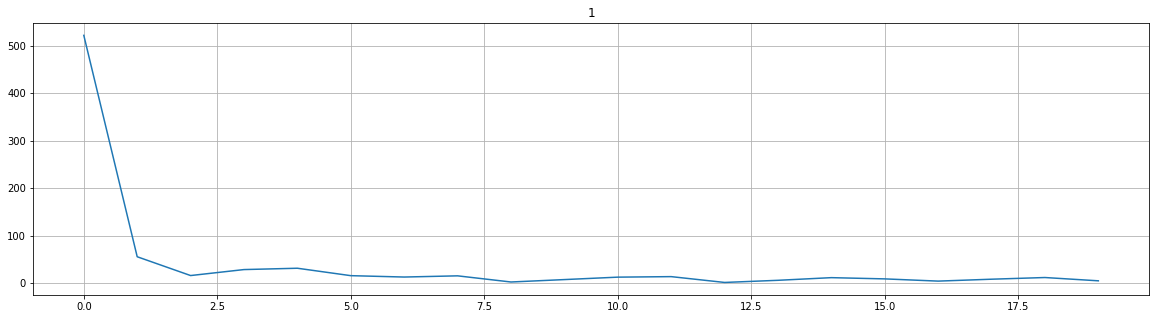

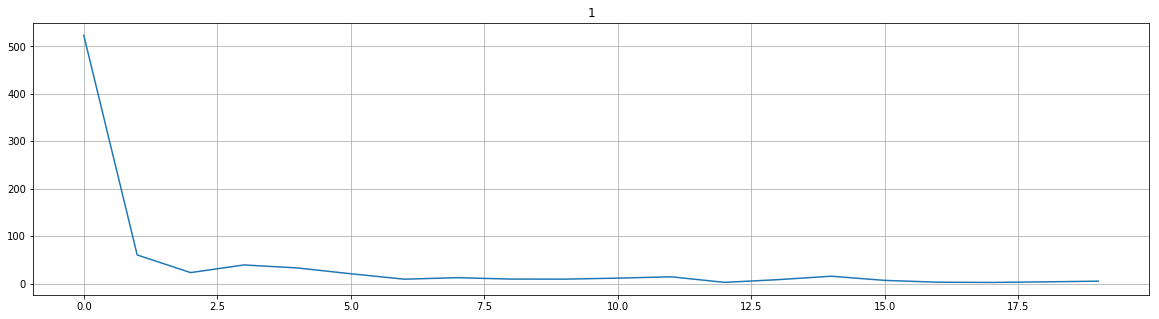

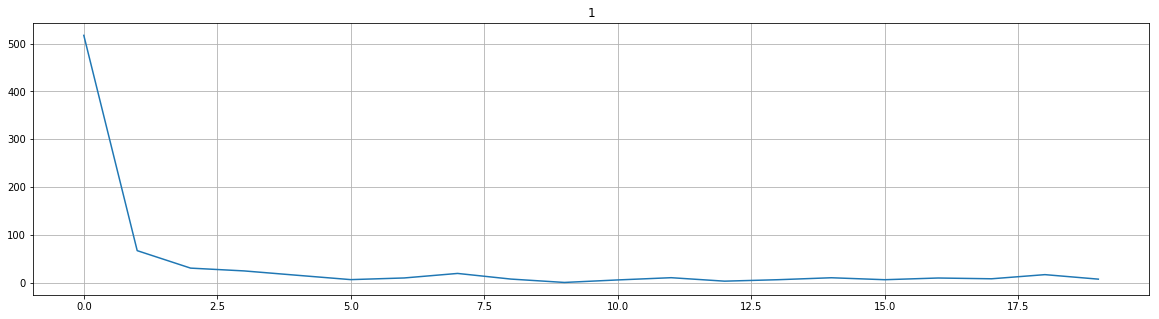

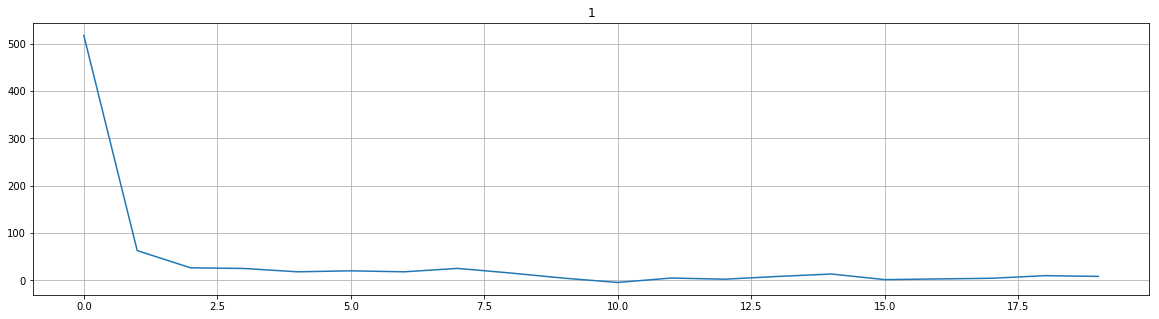

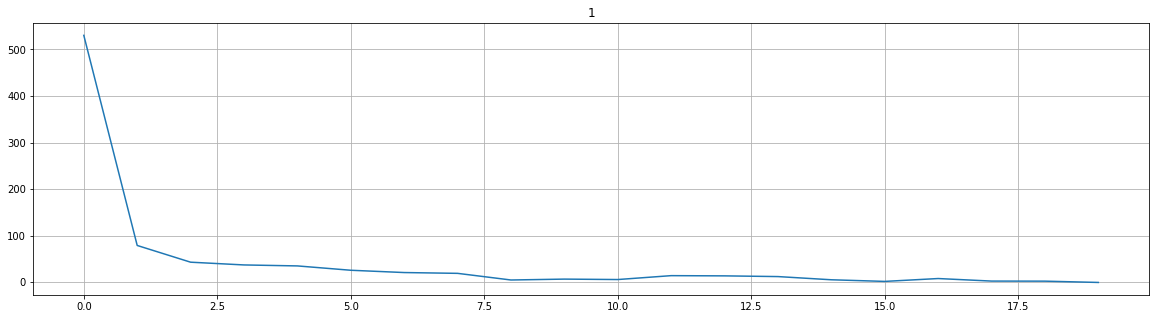

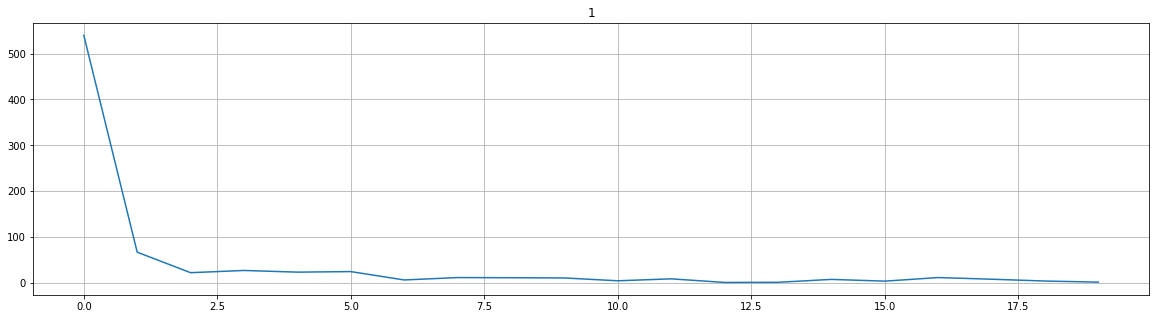

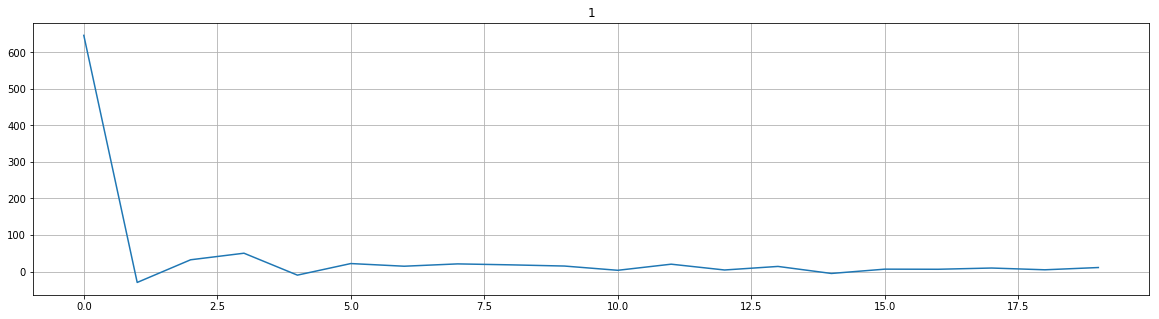

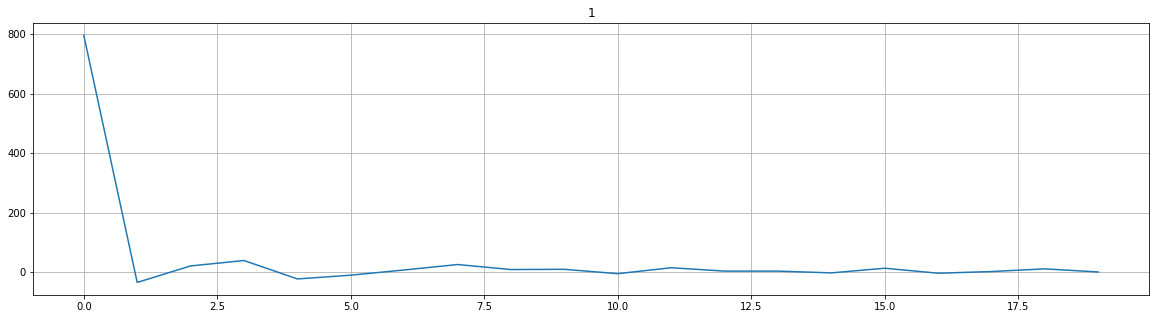

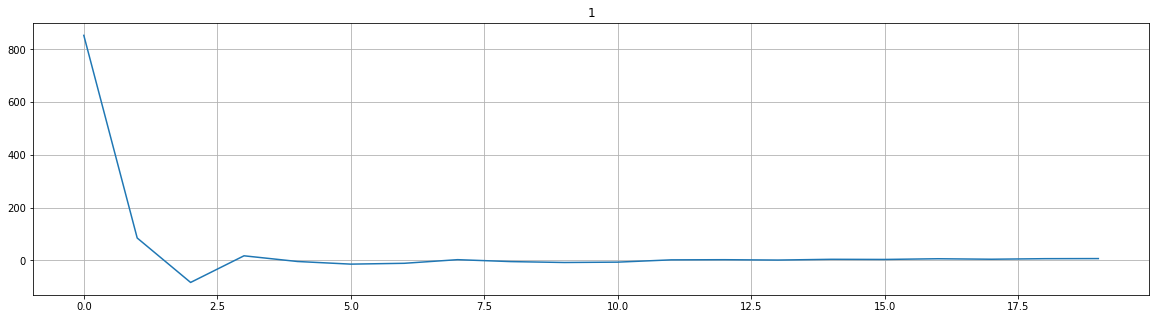

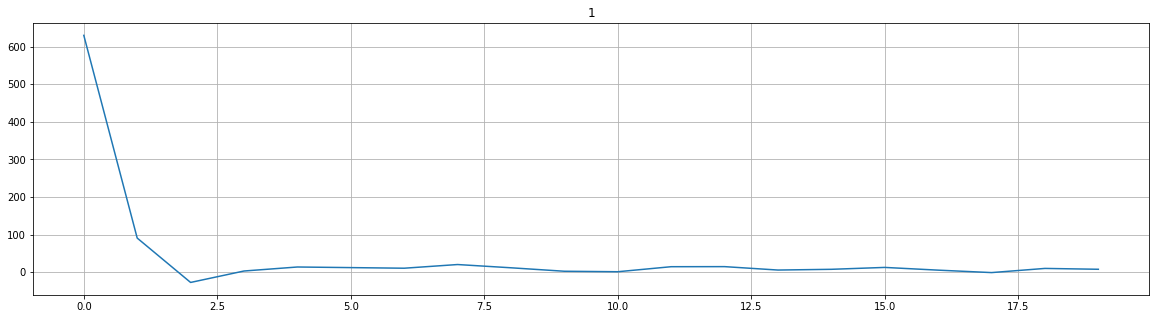

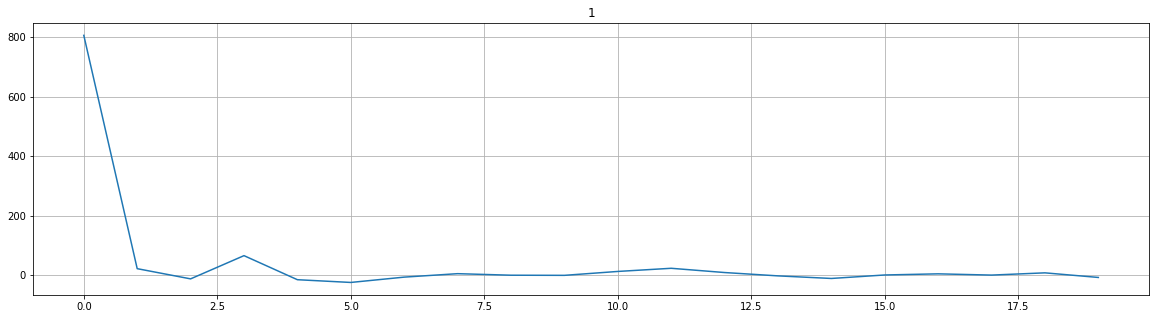

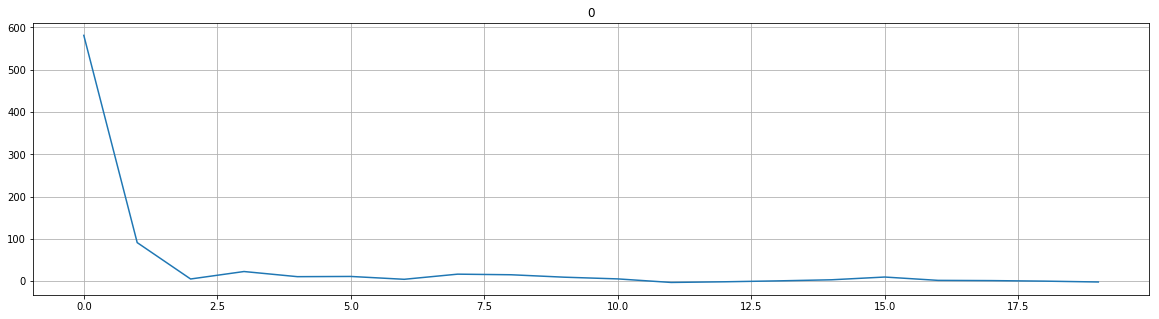

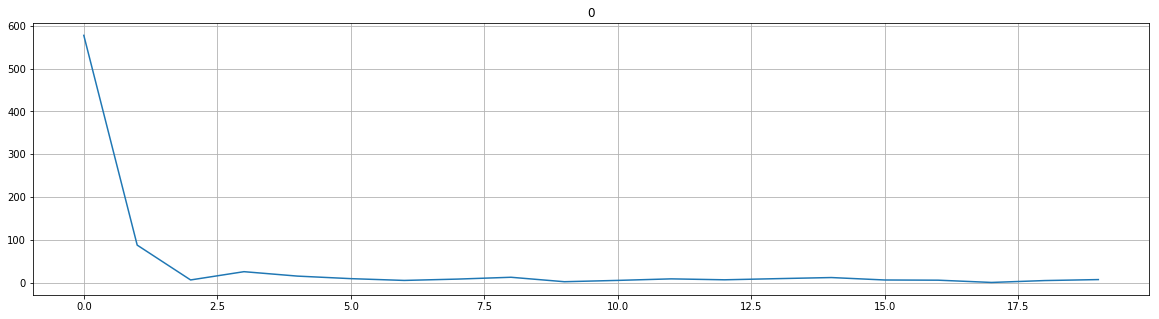

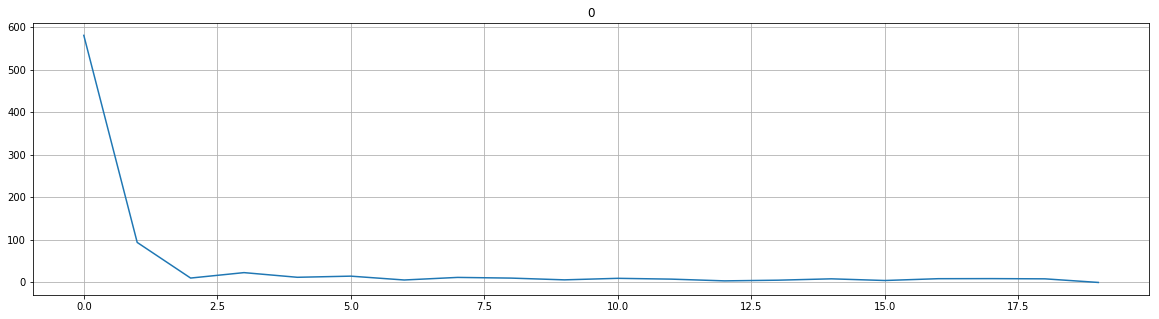

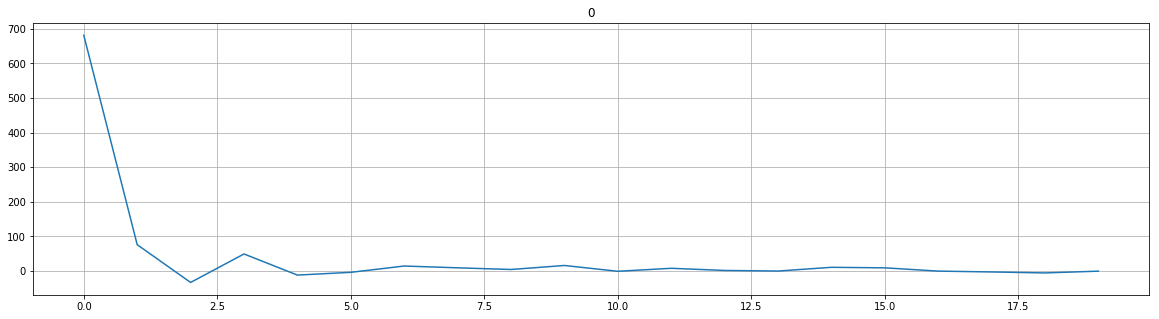

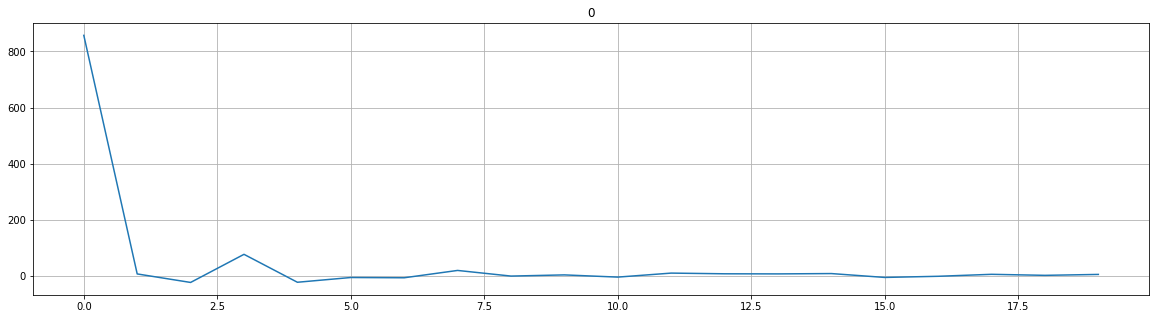

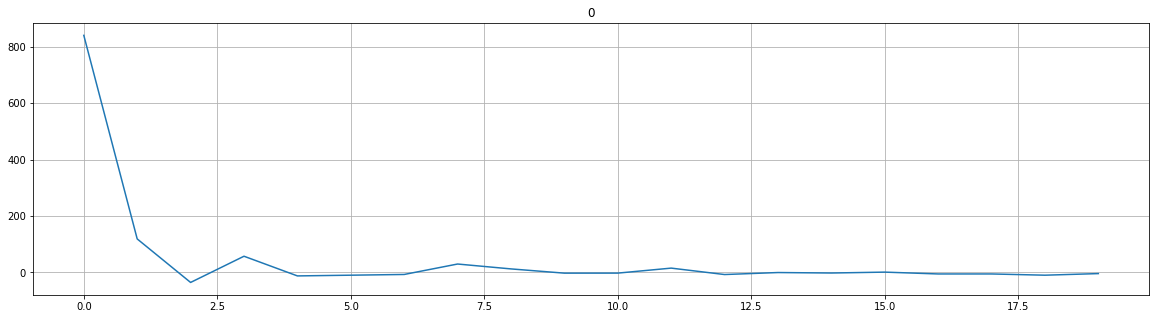

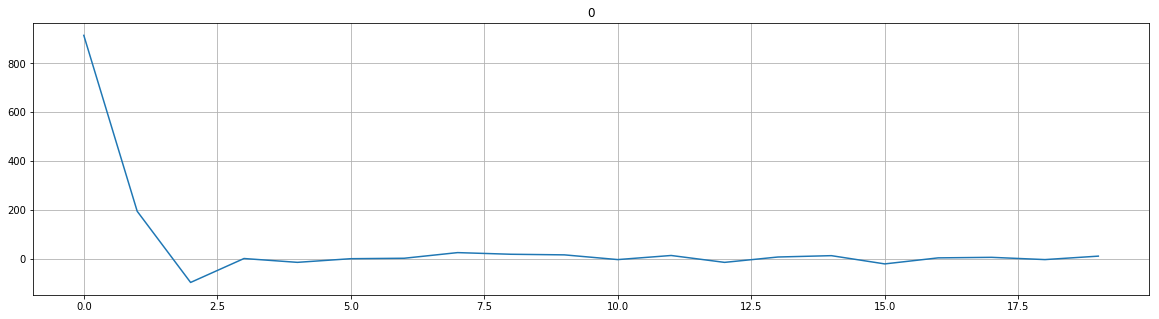

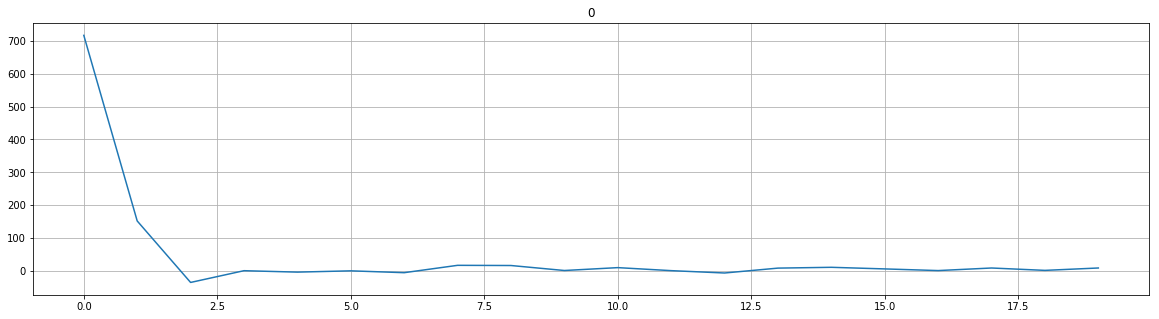

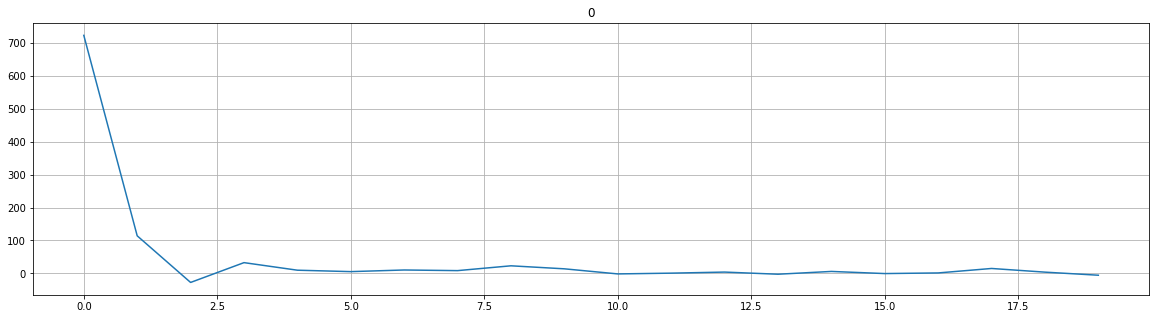

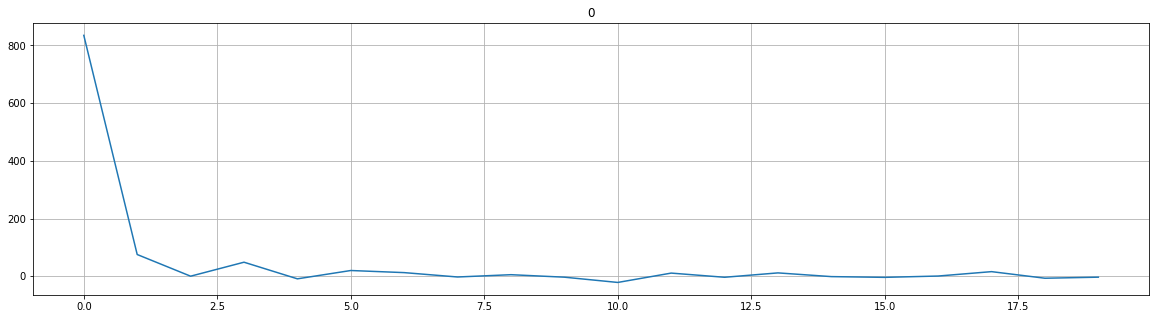

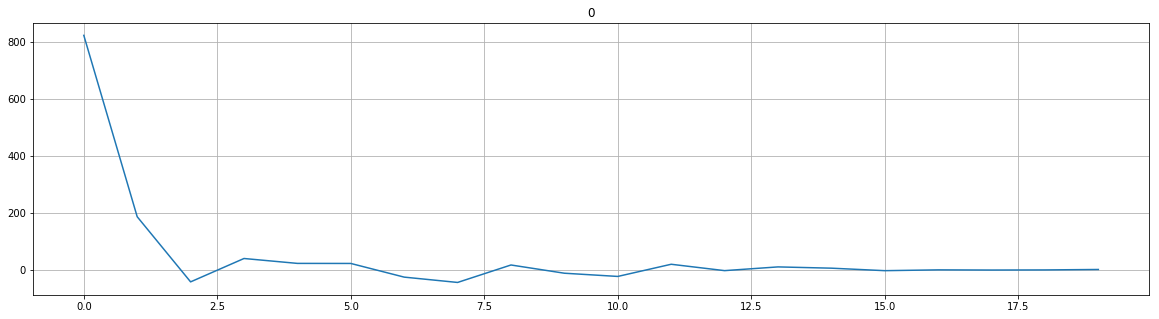

In [69]:
for e,(x,y) in enumerate(zip(X_train,y_train)):
    plt.figure(figsize=(20,5))
    plt.plot(x)
    plt.grid()
    plt.title(y)
    plt.show()
    if e > 10:
        break
e=0
for x,y in zip(X_train,y_train):
    if y == 0 :
        e+=1 
        plt.figure(figsize=(20,5))
        plt.plot(x)
        plt.grid()
        plt.title(y)
        plt.show()
    if e > 10:
        break

In [64]:
X_train = X_train.reshape(-1,20,1)
X_test = X_test.reshape(-1,20,1)

In [57]:
X_train = X_train.reshape(-1,20)
X_test = X_test.reshape(-1,20)

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers import Activation
from keras.layers import LSTM, Dense, Embedding, Bidirectional

Using TensorFlow backend.


In [45]:
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [66]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 200

# LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(20,1)))
# model.add(Dense(16, input_shape=(20,)))
# model.add(Dropout(0.2))
# model.add(Dense(8))
# model.add(Dropout(0.2))
# model.add(Dense(4))
# model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5000, 20, 1)
(5000, 2)
(591, 20, 1)
(591, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_13 (Activation)   (None, 2)                 0         
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 591 samples
Epoch 1/200
5000/5000 [==============================] - 11s - loss: 0.6485 - acc: 0.6434 - val_loss: 0.6724 - val_acc: 0.6108
Epoch 2/200
5000/5000 [==============================] - 10s - loss: 0.5656 - acc: 0.7114 - val_loss: 0.7231 - val_acc: 0.5956
Epoch 3/200
5000/5000 [==============================] 

KeyboardInterrupt: 

In [179]:
## Bidirectional version

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 200

# LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(10), input_shape=(20,1)))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
#                     validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(10000, 20, 1)
(10000, 2)
(1254, 20, 1)
(1254, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 20)                960       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10000/10000 [==============================] - 12s - loss: 0.6485 - acc: 0.6165    
Epoch 2/200
10000/10000 [==============================] - 10s - loss: 0.6180 - acc: 0.6537    
Epoch 3/200
10000/10000 [==============================] - 10s - loss: 0.6006 - acc: 0.6697    
Epoch 4/200
10000/10000 [==============================] - 10s - l

KeyboardInterrupt: 

In [47]:
print('Train...')

for epoch in range(10):
    mean_tr_acc = []
    mean_tr_loss = []
    
    for i in range(int(len(X_train)/50)):
        if i%100 == 0:
            print(i*50)
        
        ind = i
        
        Y_true = Y_train[ind*50:(ind+1)*50]
        s_true = s_train[ind]
        

        batch = X_train[i*50:(i+1)*50].T
        
        for j in range(20):
            #batch 100,20,1
            mini_batch = batch[j]
            tr_loss, tr_acc = model.train_on_batch(mini_batch.reshape(50,1,1), Y_true)
#         model.reset_states()

        mean_tr_acc.append(tr_acc)
        mean_tr_loss.append(tr_loss)
        
        
    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')
    
    
#     mean_ts_acc = []
#     mean_ts_loss = []
    
#     for i in range(int(len(X_test))):
#         if i%100 == 0:
#             print(i)

#         Y_true = Y_test[i*50:(i+1)*50]
#         s_true = s_test[i]

#         batch = X_test[i*50:(i+1)*50].T
        
#         for j in range(20):
#             ts_loss, ts_acc = model.test_on_batch(batch[j].reshape(50,1,1), np.array([Y_true]))
#         model.reset_states()

#         mean_ts_acc.append(ts_acc)
#         mean_ts_loss.append(ts_loss)

# #         if s_true != 80:
# #             if s_true != s_test[i]:
# #                 model.reset_states()

#     print('accuracy testing = {}'.format(np.mean(mean_ts_acc)))
#     print('loss testing = {}'.format(np.mean(mean_ts_loss)))
#     print('___________________________________')


Train...
0
5000
10000
accuracy training = 0.43913334608078003
loss training = 9.0401029586792
___________________________________
0
5000
10000
accuracy training = 0.43913334608078003
loss training = 9.0401029586792
___________________________________
0


KeyboardInterrupt: 

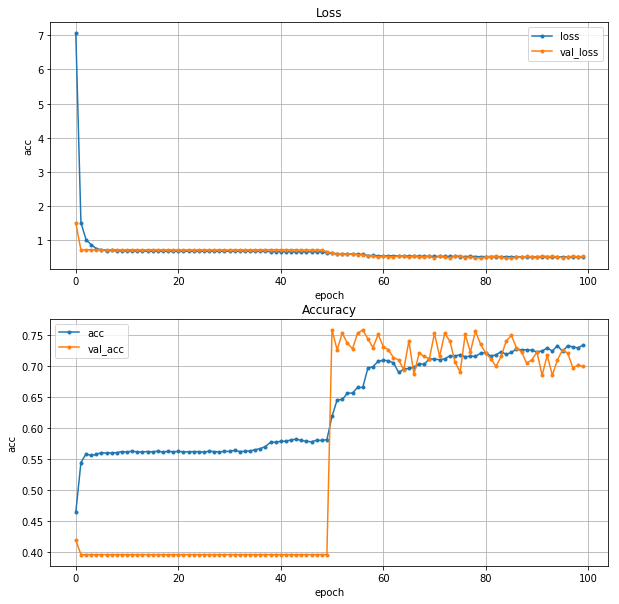

In [94]:
import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# plt.savefig('rms_cifar3_50epochs.png')

In [29]:
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
import numpy as np
import librosa


def fft_plot(data,fs):
    # fs = Sampling rate
    L = len(data) # Signal length（サンプル数）

    data_length = L /fs
    delta_freq = 1/data_length
#     print(data_length,delta_freq)
#     print("mean:",np.mean(data),"std:",np.std(data),"mean/std:",np.mean(data)/np.std(data))

    
    # 閾値
    abs_sum = []
    for i in range(int(L/100)):
        d = data[i*100:(i+1)*100]
        abs_sum.append(np.sum(np.array([np.abs(x) for x in d]))//100.)
    print(abs_sum)
    pos = 0; neg = 0
    for i in abs_sum:
        if i >= 800.:
            pos += 1
        else:
            neg += 1
    print("pos:",pos,"neg:",neg,"/",int(L/100))
    
    # 窓関数
    win = hamming(L)

    # フーリエ変換
    spectrum = fft(data * win) # 窓関数あり
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    mean = np.mean(half_spectrum)
    std = np.std(half_spectrum)
    max_val = np.max(half_spectrum)
    max_freq = np.argmax(half_spectrum)*delta_freq
    
    print("mean:",mean,"std:",std,"mean/std:",mean/std)
    
    print(np.max(half_spectrum[:10]),np.max(half_spectrum[10:]),np.max(half_spectrum[:10])/np.max(half_spectrum[10:]))
    print("max-val:",max_val,"max-freq:",max_freq,"max/std:",max_val/std)
    
    # mfccs translation
    mfccs = mfcc(data, sr=fs, n_mfcc=20, n_fft=4096)
    print("mfcc shape",mfccs.shape)
    
#     if mfccs[1] > mfccs[2]:
#         print("----OK----")
#     else:
#         print("----NG----")

    
    # 図を表示
    fig = plt.figure(figsize=(18,10))

    fig.add_subplot(311)
    plt.plot(data)
    plt.xlim([0, L])
    plt.grid()
    plt.title("1. Input signal", fontsize = 15)

    fig.add_subplot(312)
#     plt.plot(np.arange(len(spectrum))*delta_freq, spectrum)
    plt.plot(half_spectrum)
#     plt.xlim([0, len(half_spectrum)/10])
    plt.xticks([i for i in range(len(half_spectrum))][::100],[i*delta_freq for i in range(len(half_spectrum))][::100])
    plt.grid()
    plt.title("2. Spectrum (with window)", fontsize = 15)

    fig.add_subplot(313)
    plt.plot(mfccs[1:])
#     plt.xticks(np.arange(0,30),np.arange(1,31))
    plt.grid()
    plt.title("3. MFCC (without DC)", fontsize = 15)
    
    plt.show()

#     l = 512
#     data_length = l/fs
#     delta_freq = 1/data_length
#     print(data_length,delta_freq)
    
#     plt.figure(figsize=(20,10))
#     # スペクトログラムを描画
#     pxx, freqs, bins, im = plt.specgram(data, NFFT=l, Fs=fs, noverlap=0, window=hamming(l))
# #     plt.yticks(np.arange(20000)[::100],np.arange(20000)[::100]*delta_freq)
# #     plt.ylim(0,1000)
#     plt.xlabel("time [second]")
#     plt.ylabel("frequency [Hz]")

#     plt.show()
    
#     return (np.arange(len(half_spectrum))*delta_freq, half_spectrum)
    return (np.arange(len(spectrum))*delta_freq, spectrum)

In [16]:
from librosa.core import stft, spectrum
from librosa.filters import mel, dct

def mfcc(y, sr=22050, n_mfcc=20, n_fft=2048, center=False, power=2.):

    abs_spectrum = np.abs(spectrum.stft(y, n_fft=n_fft, center=False))**power

    mel_basis = mel(sr, n_fft, n_mels=512)
    melspec = np.dot(mel_basis, abs_spectrum)

    S =spectrum.power_to_db(melspec)

    return np.dot(dct(n_mfcc, S.shape[0]), S)

